In [1]:
import os, sys, argparse
from upsetplot import from_memberships
from upsetplot import plot
%matplotlib inline 
from matplotlib import pyplot
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from itertools import combinations
from comb import parse_maf, my_combs_frozenset, my_combs_all, my_combs, my_combos
from inter import intersections
from howmany import how_many_tumor_cgc
from contents import set_contents
from df import baileydf, cgcdf, pancandf
from tabulate import tabulate
from table import table
original = os.getcwd()


In [2]:
possible_callers = ('muse', 'mutect', 'somaticsniper', 'varscan')

possible_cancers = ('ACC', 'BLCA','BRCA','CESC','CHOL','COAD','DLBC','ESCA','GBM','HNSC', 
					'KICH','KIRC','KIRP','LAML','LGG','LIHC','LUAD','LUSC','MESO', 'OV','PAAD',
                    'PCPG','PRAD','READ','SARC','SKCM','STAD','TGCT','THCA','THYM','UCEC','UCS','UVM')
callers = ['muse','somaticsniper']
additional_callers = ['mutect','varscan']
keys = my_combs_frozenset(possible_callers, len(possible_callers))

impacts = set(('MODERATE', 'HIGH'))
filt = set(('PASS',))
dfcgc = cgcdf(possible_cancers, possible_callers, keys, original, impacts, filt)

In [3]:


def individual_analysis(original, cancer, possible_callers, tabu):
    os.chdir(original)
    cgc = pd.read_csv('Cancer_Gene_Census_all_Jun-11-2019.csv', usecols = (0,9))
    os.chdir(cancer)
    mafs = os.listdir()

    maf_fps = {}
    for caller in possible_callers:
        for maf in mafs:
            if caller in maf: # str in the filepath
                maf_fps[caller] = maf

    all_variants = {}
    
    for caller in maf_fps:
        all_variants[caller] = parse_maf(maf_fps[caller])
    arg = []
    for i in range(len(possible_callers)):
        arg.append(all_variants[possible_callers[i]])   
    
    
    patients = set(list(arg[0].keys()))
    for i in range(len(arg)):
        patients = patients & set(list(arg[i].keys()))

    patients = list(patients)
    
    allrealdiff = []
    alltotaldiff = []
    allreal = []
    
    total = np.zeros(4)

    for k in range(len(patients)):
        df = pd.DataFrame(0, index=keys, columns=[cancer,])
        data = dict([(key, []) for key in keys])
        sets = []
        for j in range(len(arg)):
            sets.append(arg[j][patients[k]])
        
        inters = intersections(sets)
    
        for i in range(len(inters)):
            data[keys[i]].extend(list(inters[i]))
        
        df.loc[:,cancer] = how_many_tumor_cgc(data, cgc, filt, impacts, keys)
    
        t = table(callers, additional_callers, cancer, 2, impacts, filt, keys, bcp = df, individual = True, tab = False)        
        
        totaltable = table(callers, additional_callers, cancer, 2, impacts, filt, keys, bcp = dfcgc, individual = False, tab = False)
        indexorder = list(totaltable.index)
        
        t = t.reindex(indexorder)
        
        total = total + np.array(t['real'])
    
        if all(np.isfinite(t['real % diff'])):
            allrealdiff.append(np.array(t['real % diff']))
        if all(np.isfinite(t['total % diff'])):
            alltotaldiff.append(np.array(t['total % diff']))
        if all(np.isfinite(t['% of all real'])):
            allreal.append(np.array(t['% of all real']))
    allvar = []
    averages = pd.DataFrame(0, index=t.index, columns=('mean real', 'real std', 'mean total', 'total std', 'mean all real', 'all real std'))
    averages.loc[:,'mean real'] = np.mean(np.array(allrealdiff), axis = 0)
    for i in range(len(np.array(allrealdiff))):
        allvar.append(np.array(allrealdiff)[i][0])
    
    averages.loc[:,'mean total'] = np.mean(np.array(alltotaldiff), axis = 0)
    averages.loc[:,'mean all real'] = np.mean(np.array(allreal), axis = 0)
    averages.loc[:,'real std'] = np.std(np.array(allrealdiff), axis = 0)
    averages.loc[:,'total std'] = np.std(np.array(alltotaldiff), axis = 0)
    averages.loc[:,'all real std'] = np.std(np.array(allreal), axis = 0)
    #print(averages)
    if tabu == True:
        print(cancer)
        print(tabulate(averages, headers=['variant callers', 'mean real %', 'real % std', 'mean total %', 'total % std', 'mean all real %', 'all real % std'], tablefmt='psql',floatfmt=(".0f",".3f",".3f", ".3f",".3f",".3f", ".3f")))
    return averages, np.array(allrealdiff)

ave, real = individual_analysis(original, 'BRCA', possible_callers, tabu = True)




/Users/kathrynleung/bigdatax/somatic_mafs/table.py:77: RuntimeWarning: invalid value encountered in long_scalars
  rpercent.append(100*((sums['real'][i] - sums['real'][0]) / sums['real'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:77: RuntimeWarning: divide by zero encountered in long_scalars
  rpercent.append(100*((sums['real'][i] - sums['real'][0]) / sums['real'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:83: RuntimeWarning: invalid value encountered in long_scalars
  tpercent.append(100*((sums['total'][i] - sums['total'][0]) / sums['total'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:83: RuntimeWarning: divide by zero encountered in long_scalars
  tpercent.append(100*((sums['total'][i] - sums['total'][0]) / sums['total'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:70: RuntimeWarning: invalid value encountered in true_divide
  fractions = 100*(tops/realsum)


BRCA
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        84.593 |       97.109 |         78.352 |       102.796 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        39.095 |       63.550 |         65.670 |        92.309 |            76.150 |           27.231 |
| ('muse', 'somaticsniper', 'varscan')           |        30.570 |       52.264 |         45.083 |        64.626 |            72.228 |           28.147 |
| ('muse', 'somaticsniper')                      |         0.000 |     

In [5]:
# extrapolates size from cost, assuming equal cost and equal size for each patient, assumes num variants and size are linear
# could rewrite this function to take input size as an 
def cost(original, cancer, possible_callers, size, callers, additional_callers):
    df = pd.DataFrame(0, index=possible_callers, columns=['coefficient', 'constant'])
    df['coefficient'] = [5,3,9,1]
    df['constant'] = [2,10,4,2]
    constants = 0
    coefficients = 0
    for i in range(len(callers)):
        coefficients += df.loc[callers[i]]['coefficient']
        constants +=  df.loc[callers[i]]['constant']
        
    cost = coefficients*size +constants # size of each patient, extrapolated from cost
    averages = individual_analysis(original, cancer, possible_callers, tabu = False)[0] # average patient stats
       
    costs = np.zeros(len(averages.index))

    for i in range(len(averages.index)):
        coefficient = 0
        constant = 0
        for caller in averages.index[i]:
            coefficient += df.loc[caller]['coefficient']
            constant +=  df.loc[caller]['constant']
        costs[i] = (coefficient * size + constant) 
    averages['cost'] = costs
    print(cancer)
    print(tabulate(averages, headers=['variant callers', 'mean real %', 'real % std', 'mean total %', 'total % std', 'mean all real %', 'all real % std', 'cost'], tablefmt='psql',floatfmt=(".0f",".3f",".3f", ".3f",".3f",".3f", ".3f", '.3f')))
    return averages

cost_table = cost(original, 'ACC', possible_callers, 100, ['mutect', 'varscan'], ['somaticsniper', 'muse'])


/Users/kathrynleung/bigdatax/somatic_mafs/table.py:70: RuntimeWarning: invalid value encountered in true_divide
  fractions = 100*(tops/realsum)
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:77: RuntimeWarning: invalid value encountered in long_scalars
  rpercent.append(100*((sums['real'][i] - sums['real'][0]) / sums['real'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:83: RuntimeWarning: invalid value encountered in long_scalars
  tpercent.append(100*((sums['total'][i] - sums['total'][0]) / sums['total'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:83: RuntimeWarning: divide by zero encountered in long_scalars
  tpercent.append(100*((sums['total'][i] - sums['total'][0]) / sums['total'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:77: RuntimeWarning: divide by zero encountered in long_scalars
  rpercent.append(100*((sums['real'][i] - sums['real'][0]) / sums['real'][0]))


ACC
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+----------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |     cost |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+----------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        46.062 |       60.929 |         42.306 |        54.053 |           100.000 |            0.000 | 1818.000 |
| ('muse', 'somaticsniper', 'varscan')           |        19.970 |       38.803 |         29.766 |        48.734 |            79.966 |           29.787 | 1508.000 |
| ('muse', 'somaticsniper', 'mutect')            |        18.995 |       32.052 |         25.642 |        42.958 |            80.138 |           28.561 | 1716.000 |
| ('mu

/Users/kathrynleung/bigdatax/somatic_mafs/table.py:70: RuntimeWarning: invalid value encountered in true_divide
  fractions = 100*(tops/realsum)
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:77: RuntimeWarning: invalid value encountered in long_scalars
  rpercent.append(100*((sums['real'][i] - sums['real'][0]) / sums['real'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:83: RuntimeWarning: invalid value encountered in long_scalars
  tpercent.append(100*((sums['total'][i] - sums['total'][0]) / sums['total'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:83: RuntimeWarning: divide by zero encountered in long_scalars
  tpercent.append(100*((sums['total'][i] - sums['total'][0]) / sums['total'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:77: RuntimeWarning: divide by zero encountered in long_scalars
  rpercent.append(100*((sums['real'][i] - sums['real'][0]) / sums['real'][0]))


ACC
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        46.062 |       60.929 |         42.306 |        54.053 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'varscan')           |        19.970 |       38.803 |         29.766 |        48.734 |            79.966 |           29.787 |
| ('muse', 'somaticsniper', 'mutect')            |        18.995 |       32.052 |         25.642 |        42.958 |            80.138 |           28.561 |
| ('muse', 'somaticsniper')                      |         0.000 |      

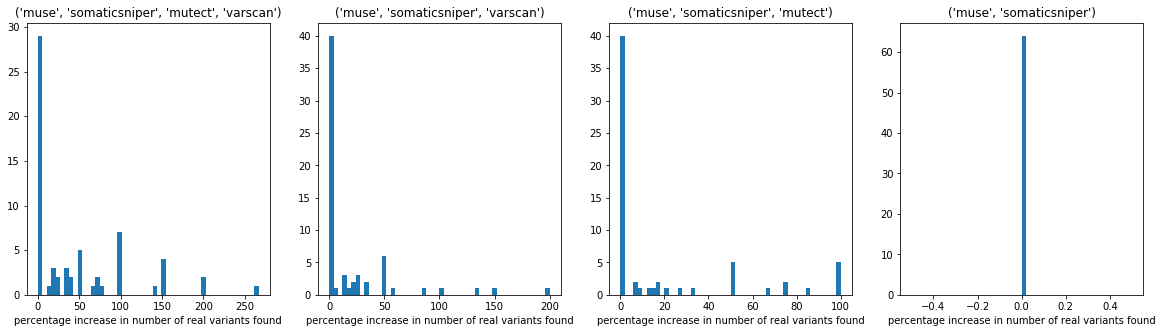

BLCA
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        67.245 |      108.658 |         39.978 |        50.011 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        41.672 |       84.612 |         33.674 |        47.522 |            86.718 |           13.180 |
| ('muse', 'somaticsniper', 'varscan')           |        31.354 |       57.182 |         19.282 |        23.209 |            82.839 |           15.100 |
| ('muse', 'somaticsniper')                      |         0.000 |     

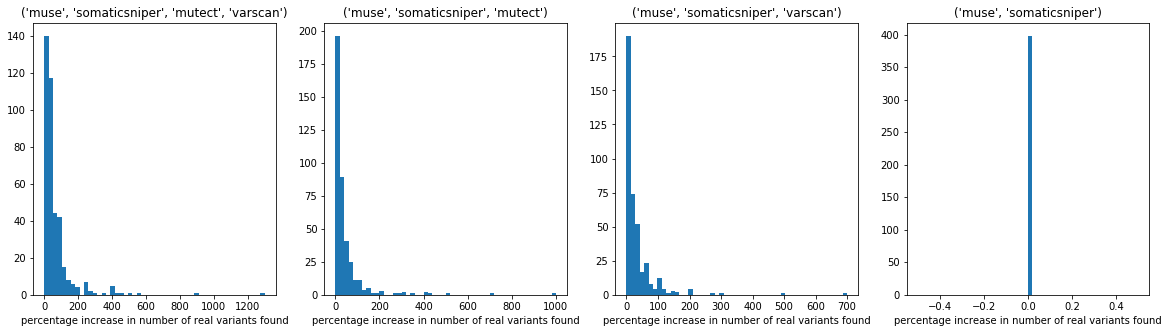

BRCA
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        84.593 |       97.109 |         78.352 |       102.796 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        39.095 |       63.550 |         65.670 |        92.309 |            76.150 |           27.231 |
| ('muse', 'somaticsniper', 'varscan')           |        30.570 |       52.264 |         45.083 |        64.626 |            72.228 |           28.147 |
| ('muse', 'somaticsniper')                      |         0.000 |     

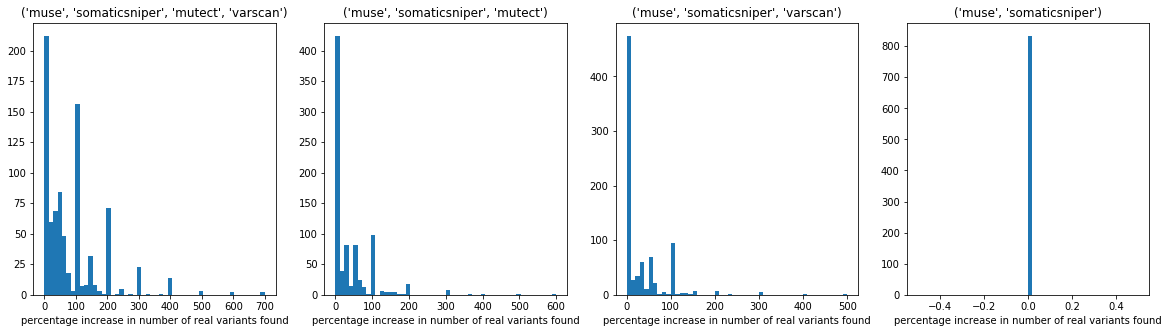

CESC
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        51.862 |       67.352 |         49.862 |       182.428 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        29.242 |       44.482 |         42.417 |       170.095 |            87.589 |           16.490 |
| ('muse', 'somaticsniper', 'varscan')           |        24.932 |       40.034 |         20.888 |        37.344 |            85.448 |           18.075 |
| ('muse', 'somaticsniper')                      |         0.000 |     

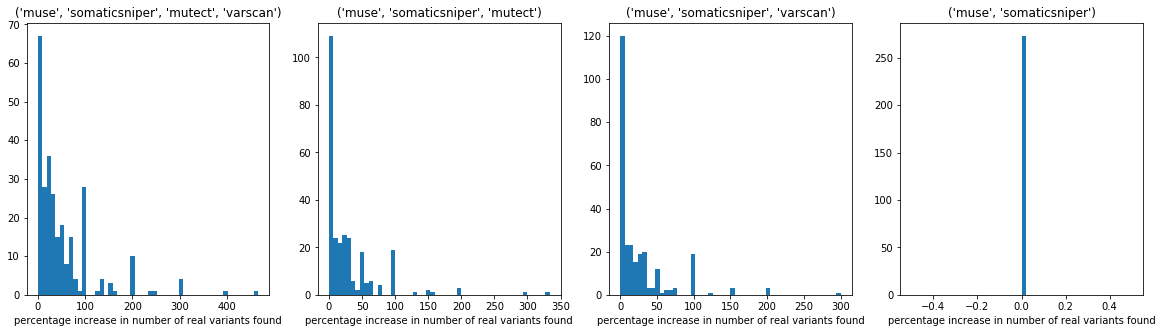

CHOL
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        66.100 |       59.615 |         82.361 |        69.813 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        22.657 |       42.380 |         65.956 |        62.173 |            69.429 |           30.754 |
| ('muse', 'somaticsniper', 'varscan')           |        20.038 |       34.038 |         49.862 |        51.105 |            68.601 |           30.194 |
| ('muse', 'somaticsniper')                      |         0.000 |     

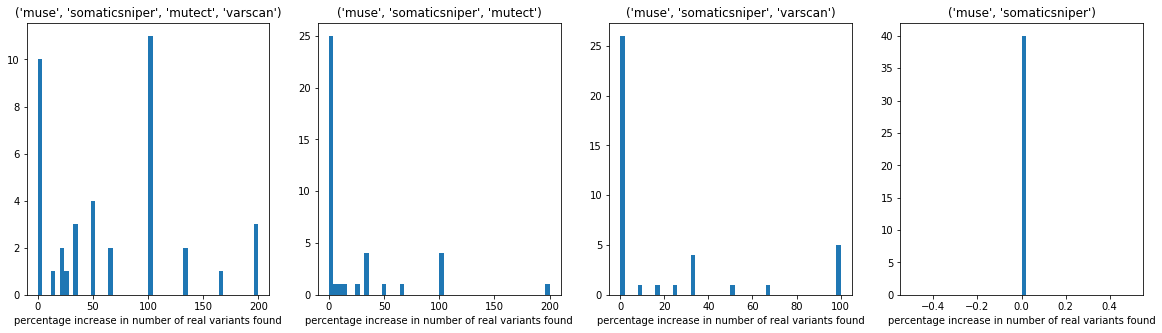

COAD
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        74.899 |      102.015 |         52.897 |       136.317 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        37.402 |       62.018 |         41.968 |       133.075 |            82.311 |           14.848 |
| ('muse', 'somaticsniper', 'varscan')           |        34.298 |       58.048 |         30.812 |        38.333 |            80.638 |           15.223 |
| ('muse', 'somaticsniper')                      |         0.000 |     

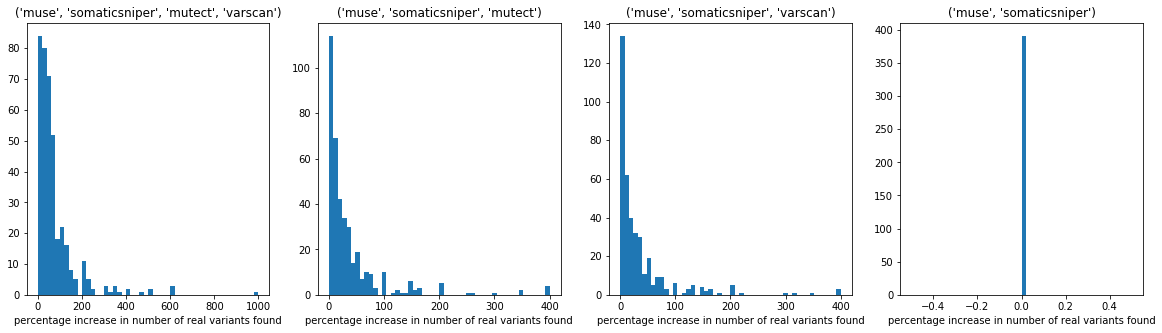

DLBC
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        49.802 |       86.656 |         40.988 |        57.639 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'varscan')           |        28.811 |       42.817 |         19.179 |        29.829 |            83.074 |           25.332 |
| ('muse', 'somaticsniper', 'mutect')            |        22.229 |       37.110 |         31.478 |        55.014 |            87.308 |           14.600 |
| ('muse', 'somaticsniper')                      |         0.000 |     

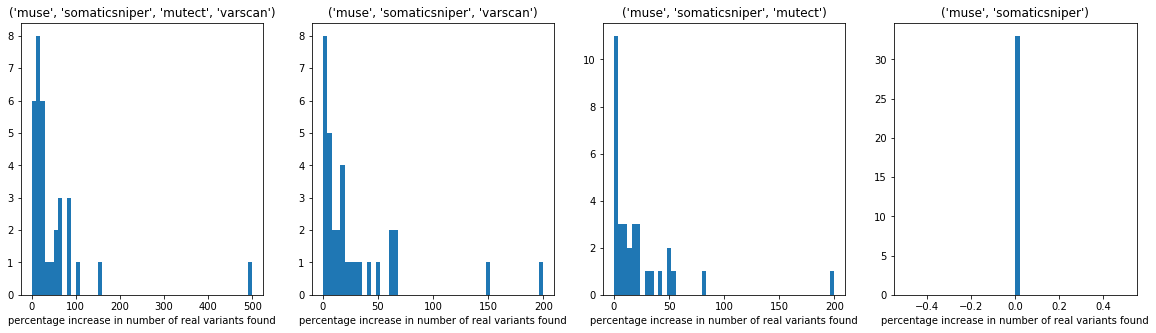

ESCA
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        59.886 |       71.328 |         45.341 |        56.317 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        30.564 |       43.450 |         36.308 |        55.405 |            83.983 |           15.705 |
| ('muse', 'somaticsniper', 'varscan')           |        28.450 |       45.394 |         27.668 |        37.079 |            82.675 |           15.465 |
| ('muse', 'somaticsniper')                      |         0.000 |     

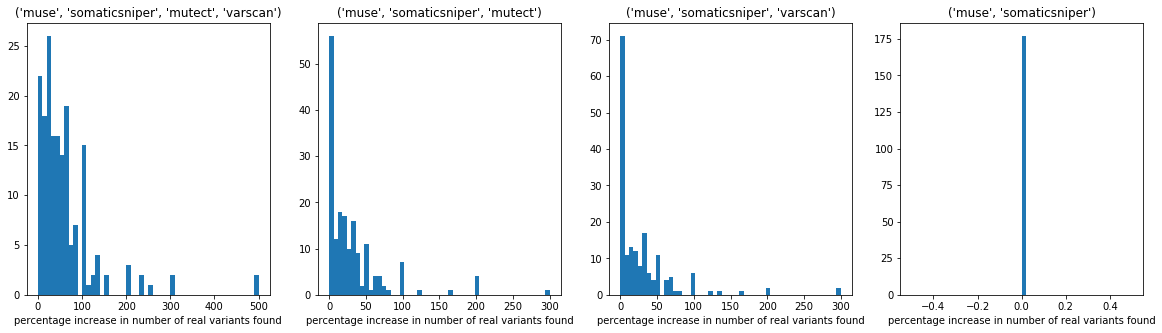

GBM
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        57.913 |       85.953 |        118.339 |       268.219 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        28.307 |       52.010 |        103.985 |       257.925 |            84.140 |           20.638 |
| ('muse', 'somaticsniper', 'varscan')           |        24.640 |       51.035 |         31.043 |        44.767 |            82.188 |           22.177 |
| ('muse', 'somaticsniper')                      |         0.000 |      

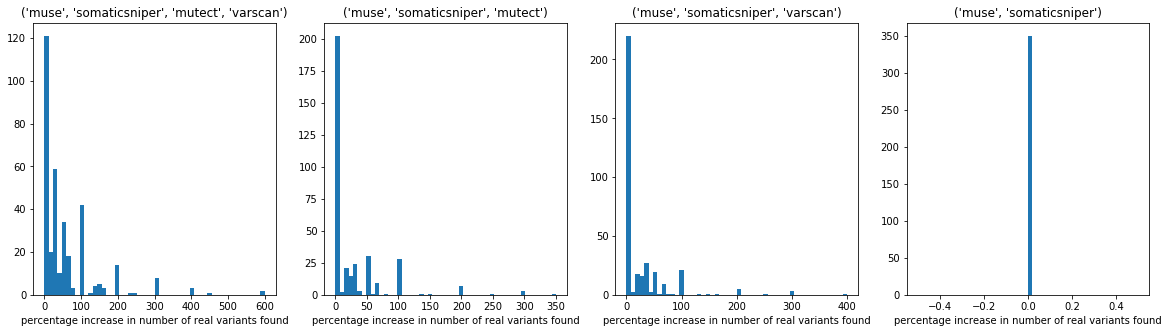

HNSC
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        88.919 |      134.780 |         43.906 |        64.190 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        54.160 |       96.235 |         38.651 |        60.424 |            84.673 |           16.526 |
| ('muse', 'somaticsniper', 'varscan')           |        46.966 |       81.439 |         23.699 |        38.259 |            81.784 |           18.851 |
| ('muse', 'somaticsniper')                      |         0.000 |     

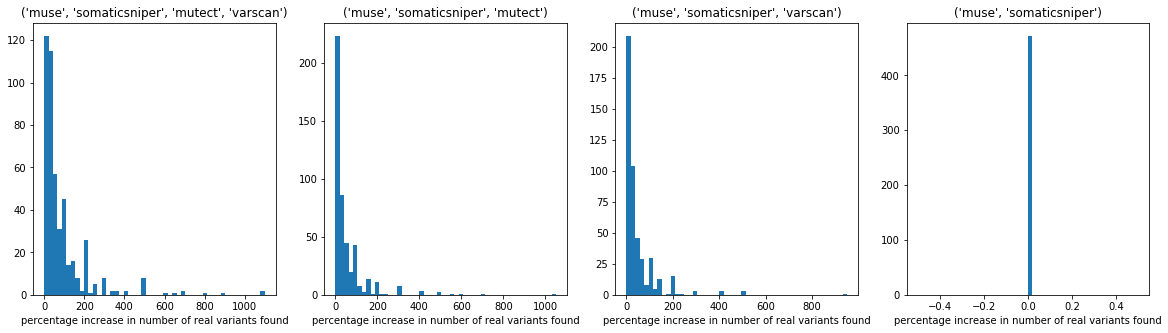

KICH
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        28.585 |       41.767 |         65.366 |        76.118 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |         8.600 |       24.436 |         45.804 |        57.370 |            83.429 |           28.960 |
| ('muse', 'somaticsniper', 'varscan')           |        10.793 |       25.488 |         33.038 |        58.296 |            80.200 |           32.770 |
| ('muse', 'somaticsniper')                      |         0.000 |     

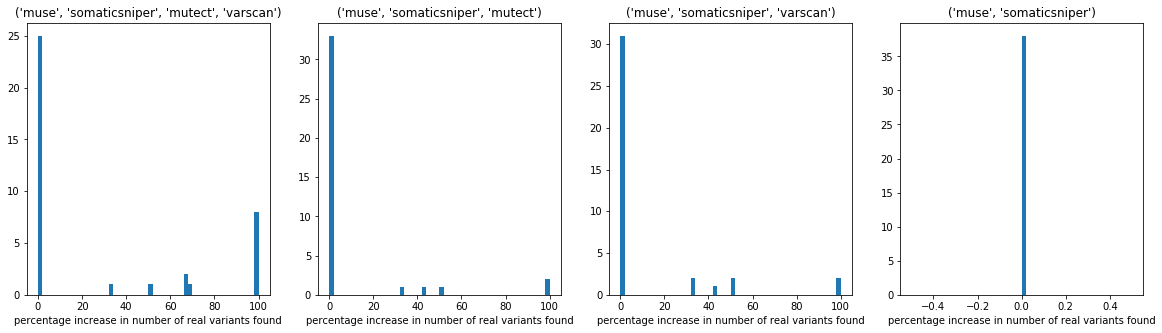

KIRC
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        97.347 |      104.463 |         81.981 |       211.367 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        37.935 |       63.881 |         72.439 |       208.848 |            71.945 |           25.465 |
| ('muse', 'somaticsniper', 'varscan')           |        34.644 |       60.844 |         49.653 |        63.850 |            69.624 |           26.705 |
| ('muse', 'somaticsniper')                      |         0.000 |     

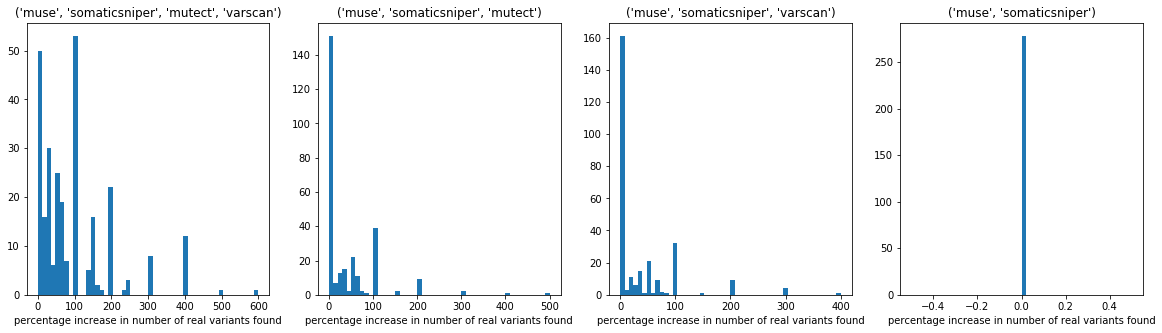

KIRP
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        46.782 |       57.008 |         49.846 |        65.207 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        13.666 |       30.691 |         39.164 |        56.475 |            80.392 |           24.602 |
| ('muse', 'somaticsniper', 'varscan')           |        12.539 |       28.402 |         35.871 |        52.616 |            79.025 |           25.148 |
| ('muse', 'somaticsniper')                      |         0.000 |     

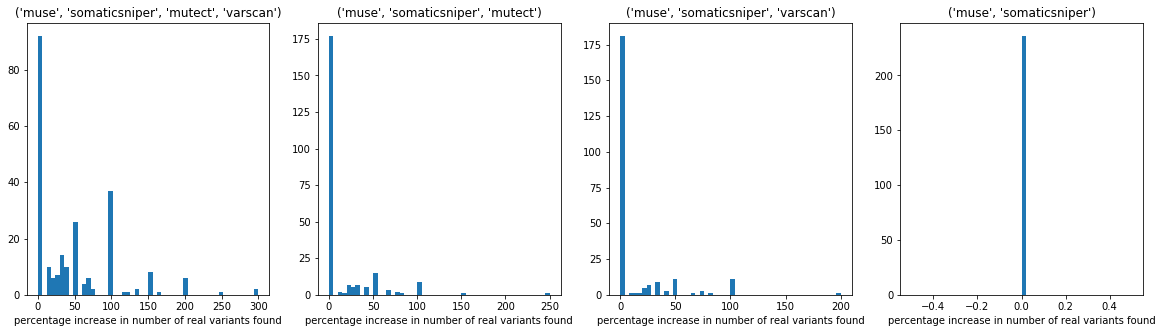

LAML
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |       112.996 |      155.535 |         73.876 |        83.605 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'varscan')           |        52.465 |       76.161 |         44.538 |        62.654 |            75.485 |           32.951 |
| ('muse', 'somaticsniper', 'mutect')            |        40.594 |      101.195 |         48.909 |        72.721 |            51.668 |           39.233 |
| ('muse', 'somaticsniper')                      |         0.000 |     

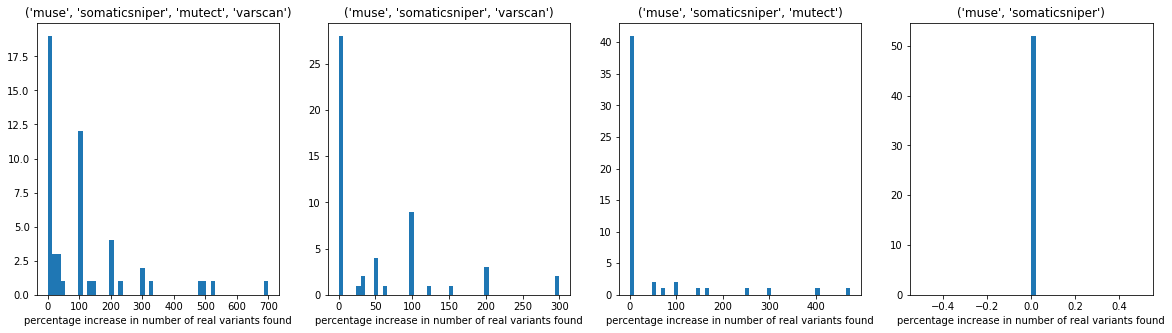

LGG
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        67.821 |       88.655 |         70.286 |        91.835 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        25.305 |       49.874 |         51.828 |        78.898 |            79.493 |           21.605 |
| ('muse', 'somaticsniper', 'varscan')           |        22.169 |       42.738 |         45.112 |        59.707 |            78.256 |           22.249 |
| ('muse', 'somaticsniper')                      |         0.000 |      

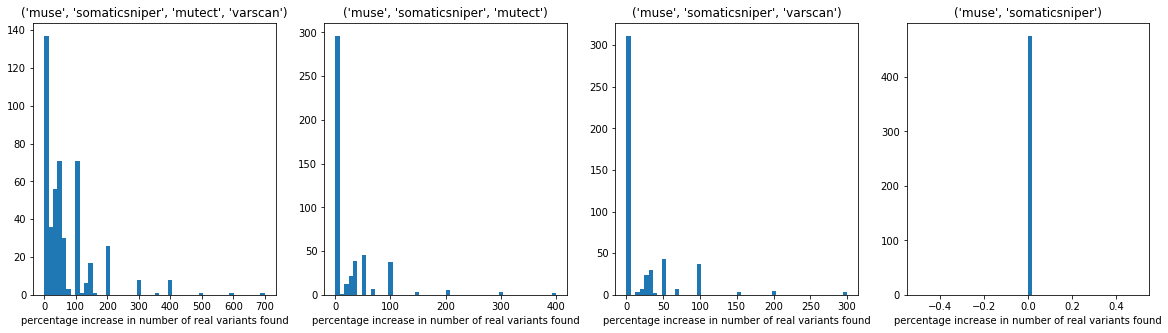

LIHC
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        51.155 |       65.721 |         43.821 |        53.760 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        25.176 |       45.163 |         36.301 |        51.265 |            85.369 |           18.312 |
| ('muse', 'somaticsniper', 'varscan')           |        22.662 |       41.953 |         25.332 |        36.576 |            83.948 |           19.048 |
| ('muse', 'somaticsniper')                      |         0.000 |     

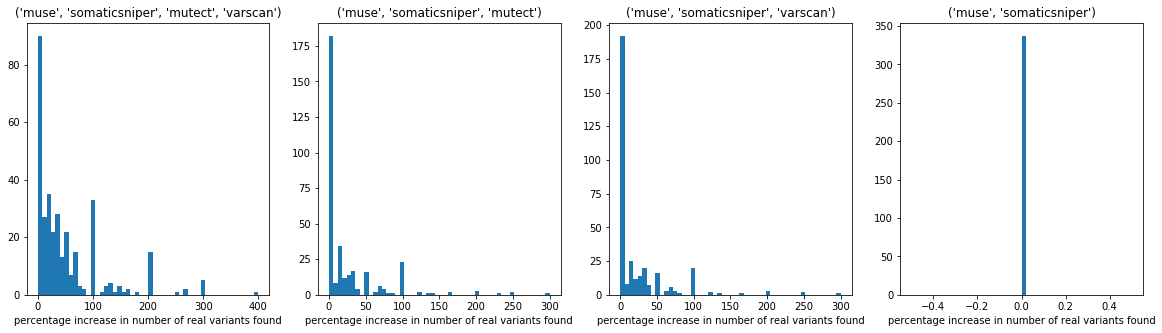

LUAD
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |       105.706 |      148.623 |         45.171 |        62.586 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        69.611 |      114.473 |         41.180 |        59.546 |            83.946 |           18.295 |
| ('muse', 'somaticsniper', 'varscan')           |        56.494 |       86.737 |         19.908 |        33.238 |            79.362 |           20.743 |
| ('muse', 'somaticsniper')                      |         0.000 |     

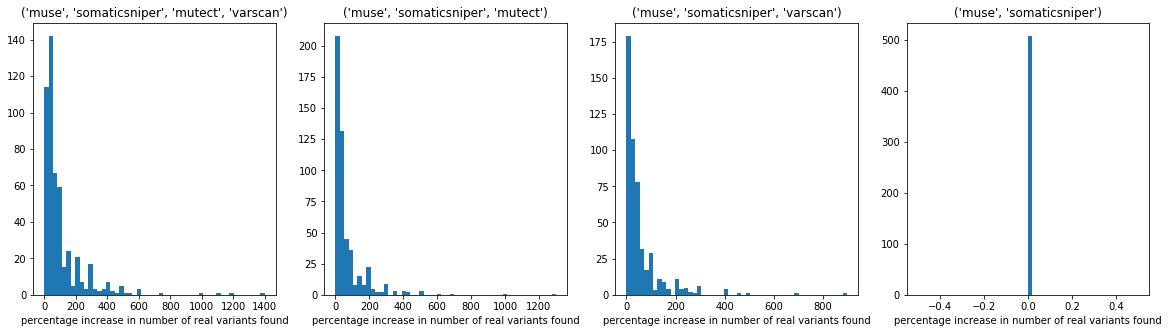

LUSC
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        75.072 |      100.665 |         30.960 |        45.009 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        50.325 |       78.380 |         26.038 |        34.652 |            88.124 |           11.905 |
| ('muse', 'somaticsniper', 'varscan')           |        42.132 |       60.294 |         15.681 |        21.144 |            84.619 |           13.882 |
| ('muse', 'somaticsniper')                      |         0.000 |     

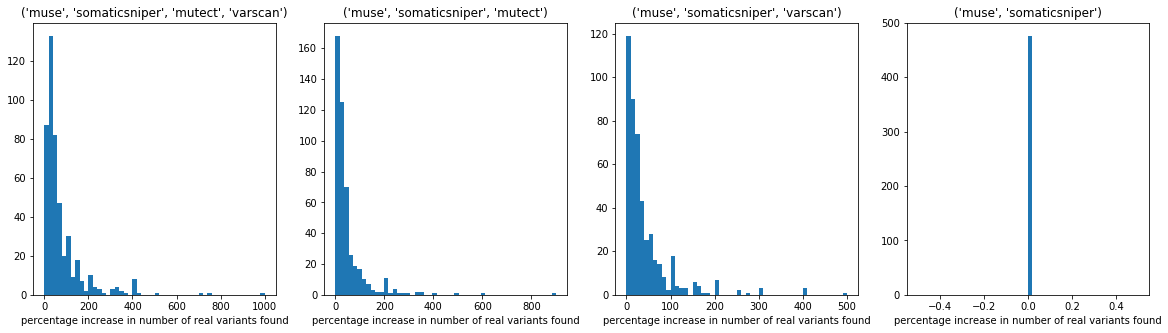

MESO
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        53.689 |       70.028 |         50.295 |        67.063 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        27.027 |       44.703 |         44.074 |        64.948 |            84.018 |           24.206 |
| ('muse', 'somaticsniper', 'varscan')           |        19.794 |       43.498 |         26.117 |        40.714 |            79.255 |           26.467 |
| ('muse', 'somaticsniper')                      |         0.000 |     

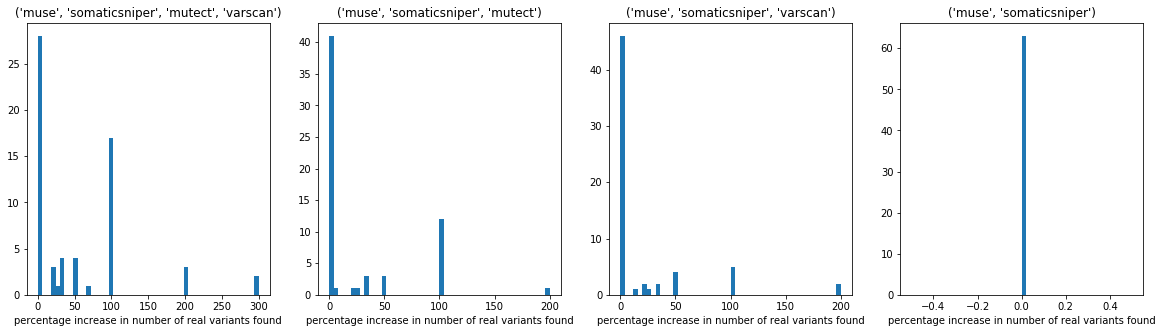

OV
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        88.572 |      105.635 |        140.897 |       250.814 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        50.968 |       77.948 |        119.355 |       217.986 |            81.620 |           20.435 |
| ('muse', 'somaticsniper', 'varscan')           |        44.319 |       66.451 |         36.164 |       122.902 |            79.676 |           19.954 |
| ('muse', 'somaticsniper')                      |         0.000 |       

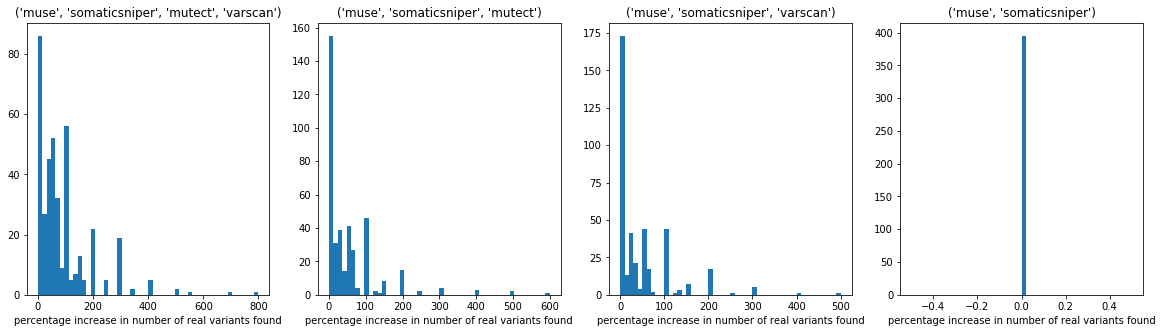

PAAD
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |       107.604 |      135.987 |         50.926 |        59.518 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        62.217 |      104.617 |         47.035 |        59.284 |            80.865 |           20.655 |
| ('muse', 'somaticsniper', 'varscan')           |        53.125 |       95.826 |         27.838 |        41.260 |            70.629 |           26.944 |
| ('muse', 'somaticsniper')                      |         0.000 |     

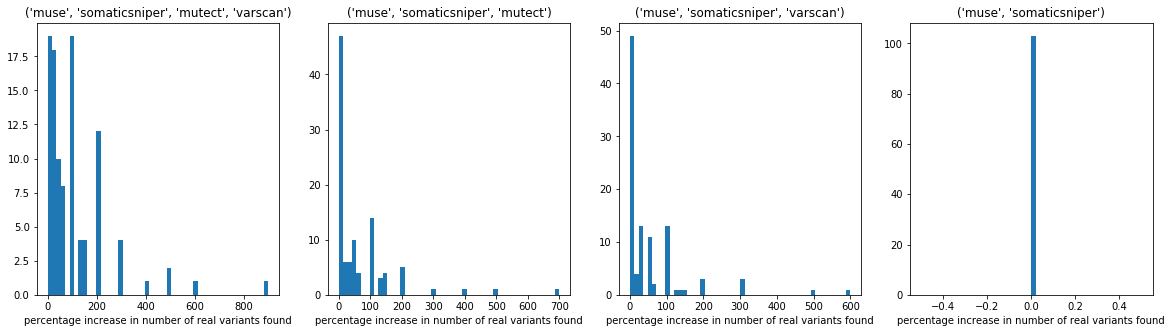

PCPG
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        15.833 |       34.950 |         33.144 |        52.072 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |         5.000 |       20.310 |         26.515 |        47.116 |            82.024 |           34.857 |
| ('muse', 'somaticsniper', 'varscan')           |         3.750 |       18.998 |         16.477 |        35.754 |            81.857 |           34.003 |
| ('muse', 'somaticsniper')                      |         0.000 |     

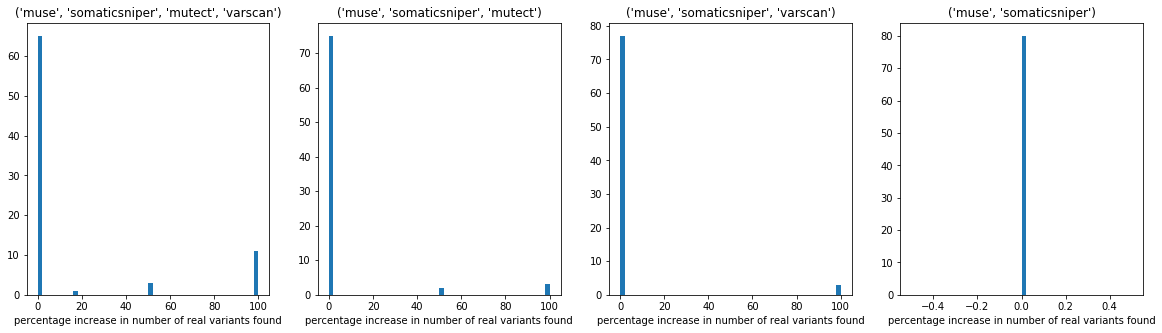

PRAD
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        60.574 |       76.023 |         59.935 |        72.844 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        22.139 |       45.828 |         55.079 |        70.100 |            76.606 |           31.635 |
| ('muse', 'somaticsniper', 'varscan')           |        18.917 |       40.972 |         30.555 |        49.009 |            71.798 |           34.558 |
| ('muse', 'somaticsniper')                      |         0.000 |     

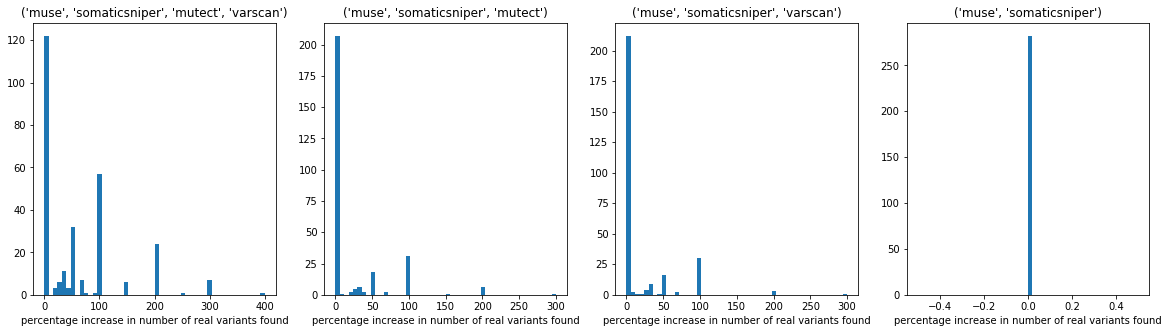

READ
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        58.867 |       60.456 |         45.818 |        40.361 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        27.919 |       41.153 |         37.161 |        38.409 |            83.189 |           13.677 |
| ('muse', 'somaticsniper', 'varscan')           |        23.842 |       32.005 |         26.906 |        24.959 |            81.347 |           13.864 |
| ('muse', 'somaticsniper')                      |         0.000 |     

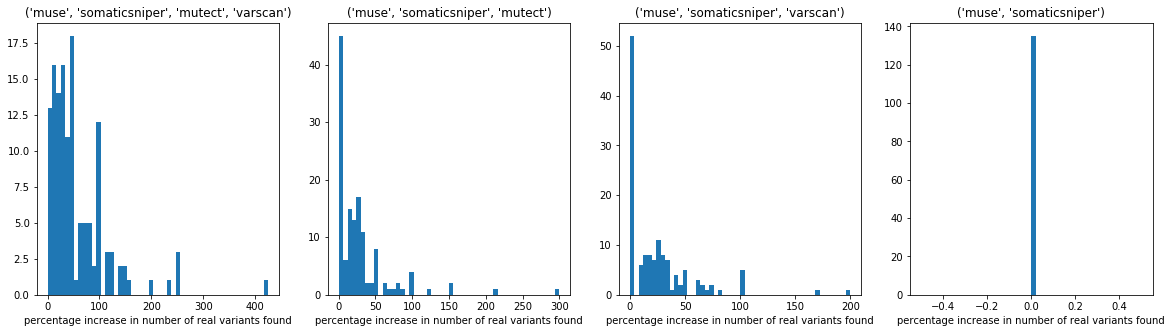

SARC
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        60.433 |       81.724 |         85.075 |       155.148 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        24.996 |       46.892 |         64.848 |       111.928 |            80.162 |           26.841 |
| ('muse', 'somaticsniper', 'varscan')           |        21.280 |       41.328 |         44.396 |        90.394 |            78.266 |           27.417 |
| ('muse', 'somaticsniper')                      |         0.000 |     

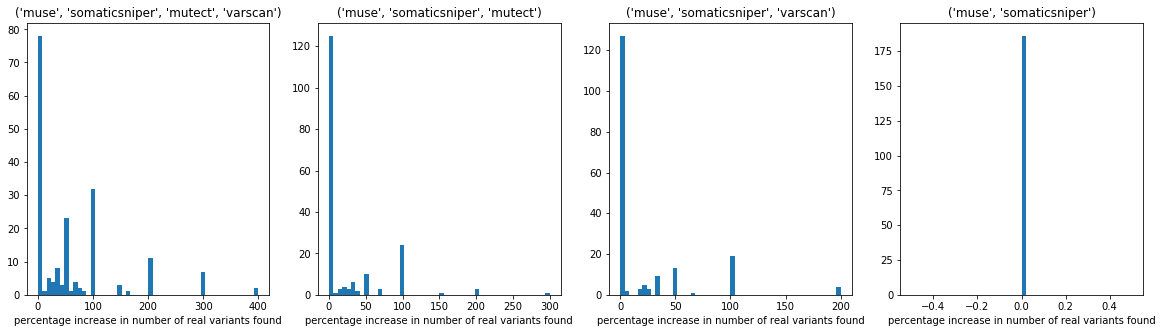

SKCM
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        52.822 |      115.460 |         25.456 |        67.201 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        35.011 |       77.877 |         20.543 |        60.286 |            90.531 |           15.296 |
| ('muse', 'somaticsniper', 'varscan')           |        30.898 |       66.159 |         12.647 |        35.917 |            88.775 |           16.277 |
| ('muse', 'somaticsniper')                      |         0.000 |     

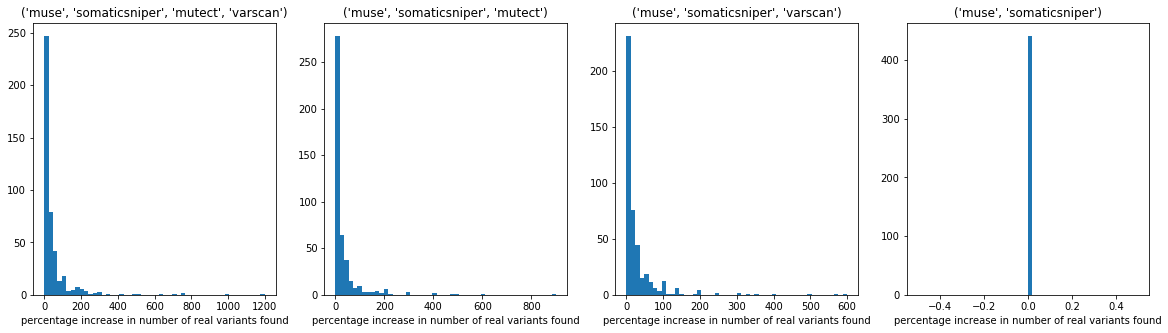

STAD
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |       112.596 |      157.118 |         59.245 |        86.432 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        66.743 |      116.400 |         52.228 |        82.822 |            81.341 |           18.910 |
| ('muse', 'somaticsniper', 'varscan')           |        51.587 |       87.590 |         30.025 |        48.697 |            76.434 |           19.213 |
| ('muse', 'somaticsniper')                      |         0.000 |     

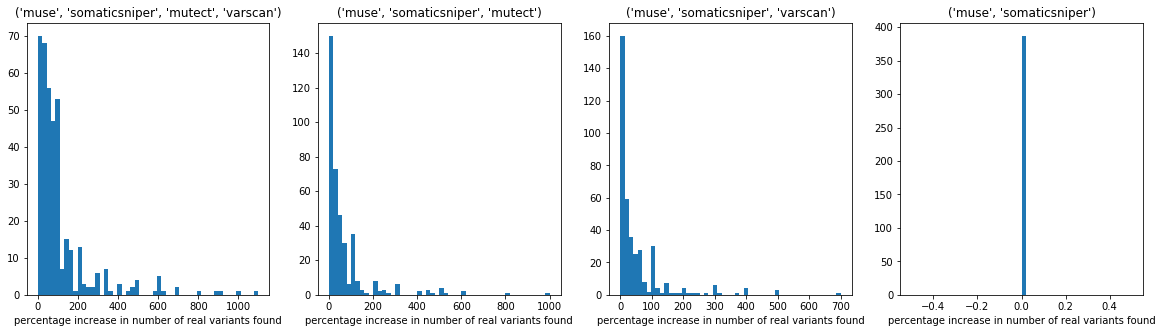

TGCT
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        41.795 |       63.254 |         51.140 |        62.064 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        26.667 |       58.163 |         29.167 |        45.009 |            83.870 |           30.281 |
| ('muse', 'somaticsniper', 'varscan')           |        21.795 |       49.435 |         34.254 |        56.629 |            80.822 |           32.401 |
| ('muse', 'somaticsniper')                      |         0.000 |     

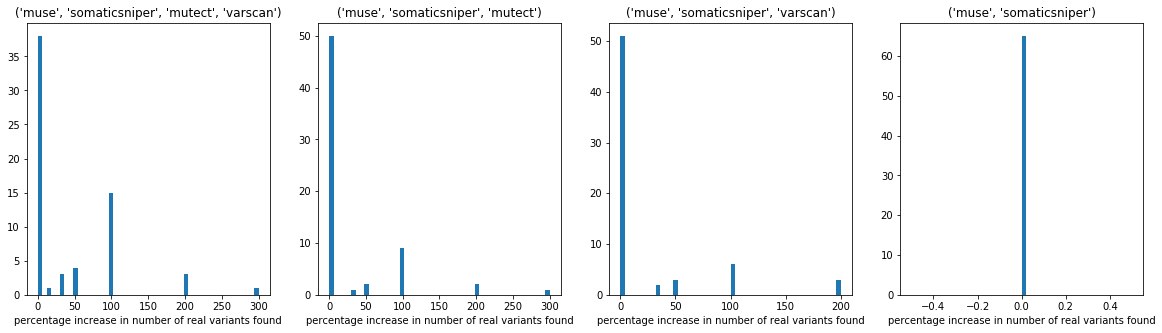

THCA
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        14.131 |       38.335 |         42.889 |       194.845 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |         7.139 |       28.424 |         41.578 |       194.545 |            93.568 |           19.600 |
| ('muse', 'somaticsniper', 'varscan')           |         5.312 |       23.812 |          6.849 |        23.751 |            92.217 |           21.449 |
| ('muse', 'somaticsniper')                      |         0.000 |     

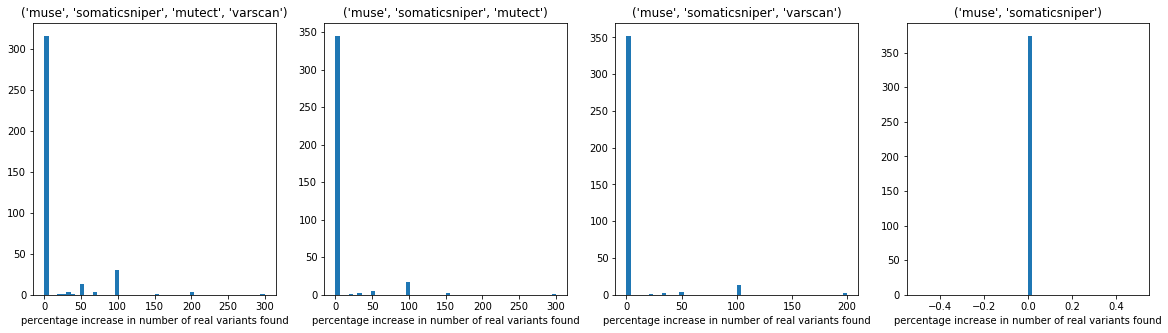

THYM
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        35.692 |       49.167 |         55.224 |        72.903 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        17.153 |       34.501 |         43.319 |        68.882 |            88.650 |           21.997 |
| ('muse', 'somaticsniper', 'varscan')           |        15.801 |       32.127 |         24.441 |        40.008 |            86.756 |           22.511 |
| ('muse', 'somaticsniper')                      |         0.000 |     

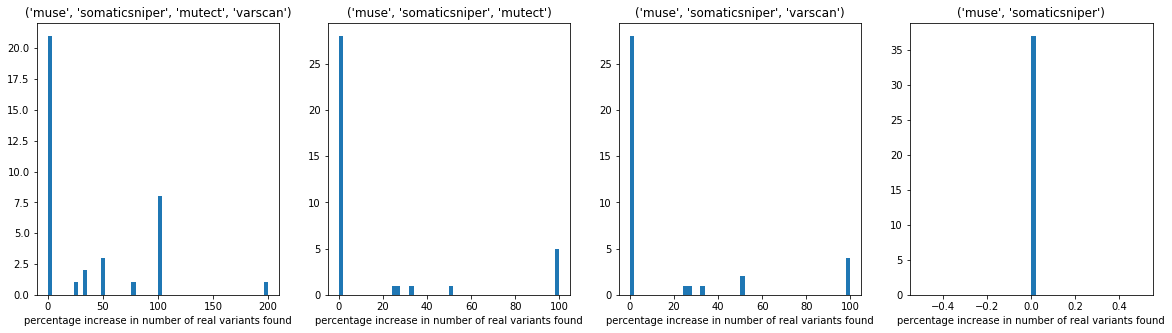

UCEC
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        55.166 |       54.414 |         72.163 |       140.906 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        20.042 |       31.905 |         60.053 |       138.238 |            80.180 |           15.574 |
| ('muse', 'somaticsniper', 'varscan')           |        17.112 |       29.254 |         36.755 |        36.958 |            78.485 |           16.242 |
| ('muse', 'somaticsniper')                      |         0.000 |     

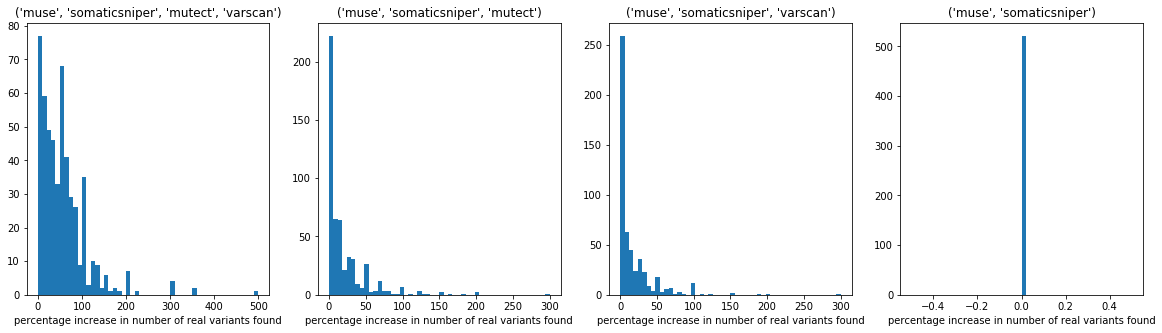

UCS
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        57.586 |       66.934 |         44.178 |        28.108 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        27.639 |       37.690 |         28.356 |        23.867 |            84.773 |           13.923 |
| ('muse', 'somaticsniper', 'varscan')           |        30.050 |       48.941 |         26.334 |        24.044 |            85.118 |           13.718 |
| ('muse', 'somaticsniper')                      |         0.000 |      

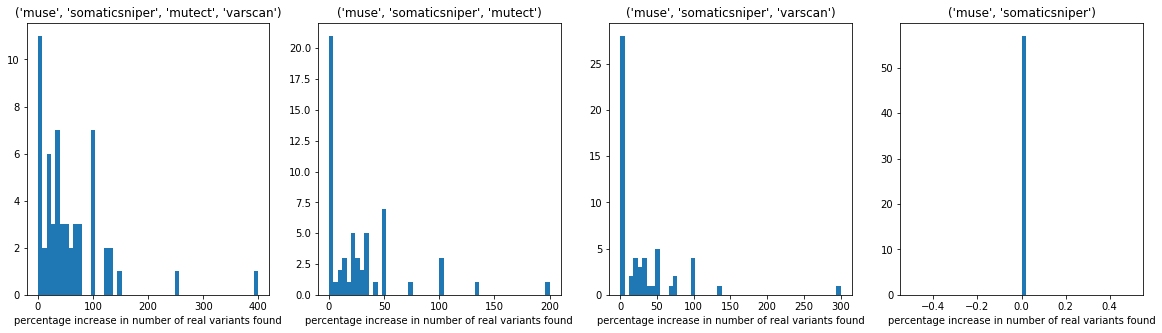

UVM
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('muse', 'somaticsniper', 'mutect', 'varscan') |        20.717 |       45.639 |         38.159 |        57.176 |           100.000 |            0.000 |
| ('muse', 'somaticsniper', 'mutect')            |        10.000 |       26.166 |         27.669 |        39.232 |            94.861 |           12.955 |
| ('muse', 'somaticsniper', 'varscan')           |         7.679 |       24.833 |         13.939 |        33.150 |            93.299 |           14.100 |
| ('muse', 'somaticsniper')                      |         0.000 |      

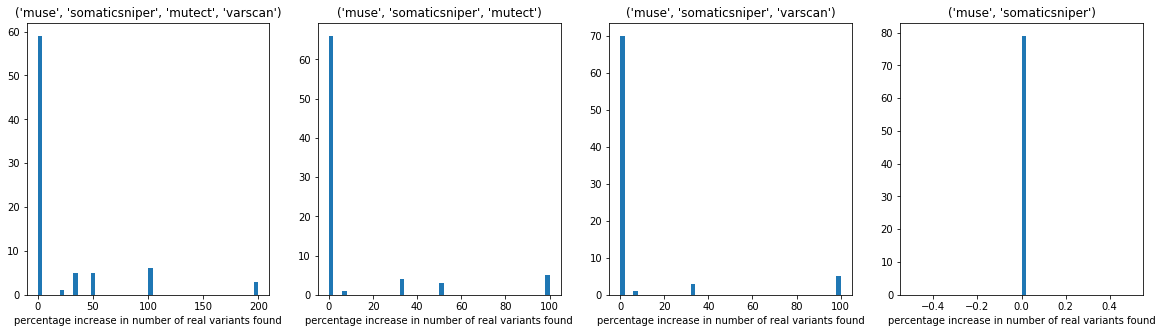

In [6]:
for cancer in possible_cancers:
    # allrealdiff
    ave, real = individual_analysis(original, cancer, possible_callers, tabu = True)
    realhist = dict([(ind, []) for ind in ave.index])
    df = pd.DataFrame(0, index=ave.index, columns=['0%', '> 0%', '>= 25%', 
                                                   '>= 50%', '>= 75%', '>= 100%'])
    # 0% increase, greater than 0, greater than 25, greater than 75, greater than 100
    zc = []
    z = []
    tf = []
    f = []
    sf = []
    oh = []
    for i in range(len(ave.index)):
        
        zerocount = [j for j in real[:,i] if j == 0]
        zero = [j for j in real[:,i] if j > 0]
        twenty_five = [j for j in real[:,i] if j >= 25]
        fifty = [j for j in real[:,i] if j >= 50]
        seventy_five = [j for j in real[:,i] if j >=75]
        one_hundred = [j for j in real[:,i] if j >=100]
        
        realhist[ave.index[i]]=real[:,i]
    
        
        zc.append(len(zerocount)/len(realhist[ave.index[i]]))
        
        z.append(len(zero)/len(realhist[ave.index[i]]))
        
        tf.append(len(twenty_five)/len(realhist[ave.index[i]]))
        
        f.append(len(fifty)/len(realhist[ave.index[i]]))
        
        sf.append(len(seventy_five)/len(realhist[ave.index[i]]))
        
        oh.append(len(one_hundred)/len(realhist[ave.index[i]]))
    
        counts = np.histogram(realhist[ave.index[i]], bins = 50)
    fig, ax = pyplot.subplots(1,4, figsize = (20,5))
    ax[0].hist(realhist[ave.index[0]], bins = 50)
    ax[0].set_title(ave.index[0])
    ax[0].set_xlabel('percentage increase in number of real variants found')
    ax[1].hist(realhist[ave.index[1]], bins = 50)
    ax[1].set_title(ave.index[1])
    ax[1].set_xlabel('percentage increase in number of real variants found')
    ax[2].hist(realhist[ave.index[2]], bins = 50)
    ax[2].set_title(ave.index[2])
    ax[2].set_xlabel('percentage increase in number of real variants found')
    ax[3].hist(realhist[ave.index[3]], bins = 50)
    ax[3].set_title(ave.index[3])
    ax[3].set_xlabel('percentage increase in number of real variants found')
    df['0%'] = zc
    df['> 0%'] = z
    df['>= 25%'] = tf
    df['>= 50%'] = f
    df['>= 75%'] = sf
    df['>= 100%'] = oh
    print(tabulate(df, headers=['variant callers', '= 0%', '> 0%', '>= 25%', '>= 50%', '>= 75%', '>= 100%'], tablefmt='psql',floatfmt=(".0f",".3f",".3f", ".3f",".3f",".3f", ".3f")))
    pyplot.show()
    #print(realhist)

In [7]:
os.chdir(original)
tcga= pd.read_excel(open('TCGA-CDR-SupplementalTableS1.xlsx', 'rb'), sheet_name='TCGA-CDR')

In [8]:
import re
ascat = pd.read_csv('ascat_acf_ploidy.tsv', sep='\t', header=0)
ascat_patients = []

for patient in ascat['Sample']:
    replaced = re.sub('[.]', '-', patient[:12])
    ascat_patients.append(replaced)
    
ascat['Sample'] = ascat_patients

cgc = pd.read_csv('Cancer_Gene_Census_all_Jun-11-2019.csv', usecols = (0,9))

/Users/kathrynleung/bigdatax/somatic_mafs/table.py:70: RuntimeWarning: invalid value encountered in true_divide
  fractions = 100*(tops/realsum)
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:77: RuntimeWarning: invalid value encountered in long_scalars
  rpercent.append(100*((sums['real'][i] - sums['real'][0]) / sums['real'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:83: RuntimeWarning: invalid value encountered in long_scalars
  tpercent.append(100*((sums['total'][i] - sums['total'][0]) / sums['total'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:83: RuntimeWarning: divide by zero encountered in long_scalars
  tpercent.append(100*((sums['total'][i] - sums['total'][0]) / sums['total'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:77: RuntimeWarning: divide by zero encountered in long_scalars
  rpercent.append(100*((sums['real'][i] - sums['real'][0]) / sums['real'][0]))


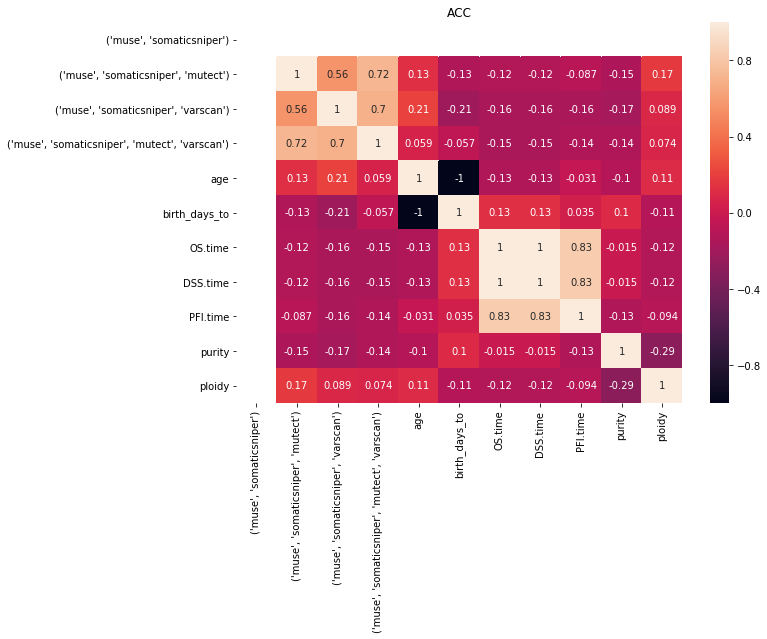

/Users/kathrynleung/bigdatax/somatic_mafs/table.py:77: RuntimeWarning: invalid value encountered in long_scalars
  rpercent.append(100*((sums['real'][i] - sums['real'][0]) / sums['real'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:77: RuntimeWarning: divide by zero encountered in long_scalars
  rpercent.append(100*((sums['real'][i] - sums['real'][0]) / sums['real'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:83: RuntimeWarning: invalid value encountered in long_scalars
  tpercent.append(100*((sums['total'][i] - sums['total'][0]) / sums['total'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:83: RuntimeWarning: divide by zero encountered in long_scalars
  tpercent.append(100*((sums['total'][i] - sums['total'][0]) / sums['total'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:70: RuntimeWarning: invalid value encountered in true_divide
  fractions = 100*(tops/realsum)


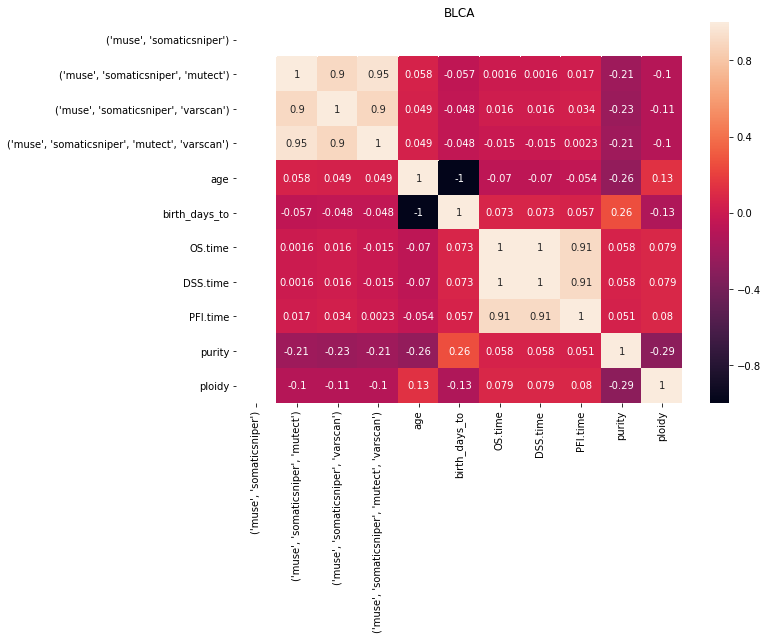

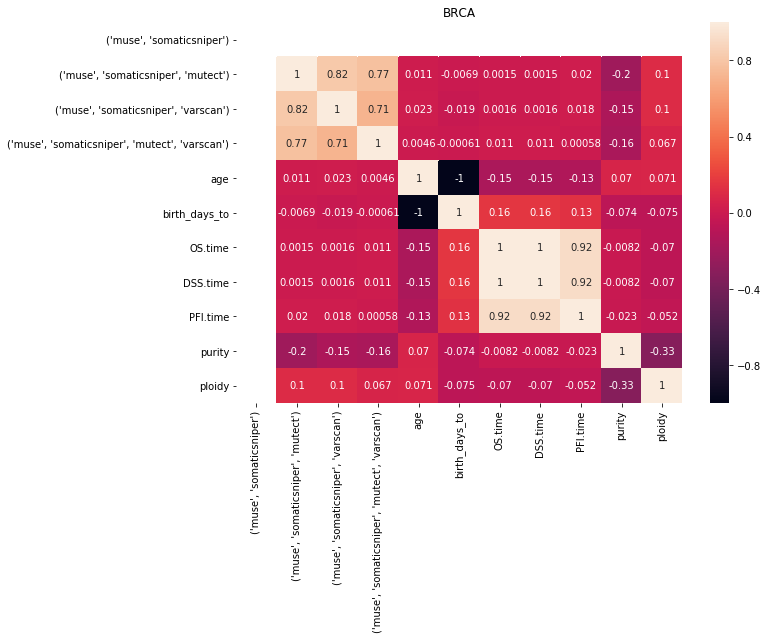

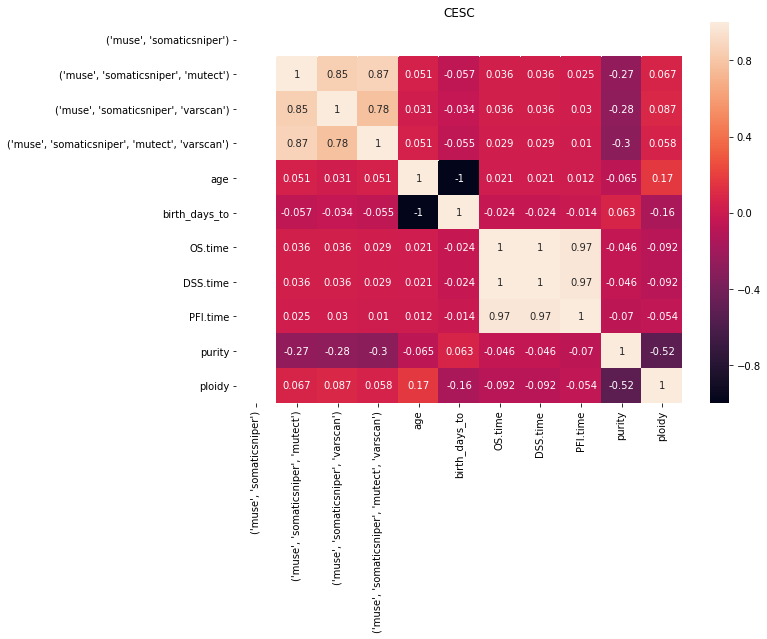

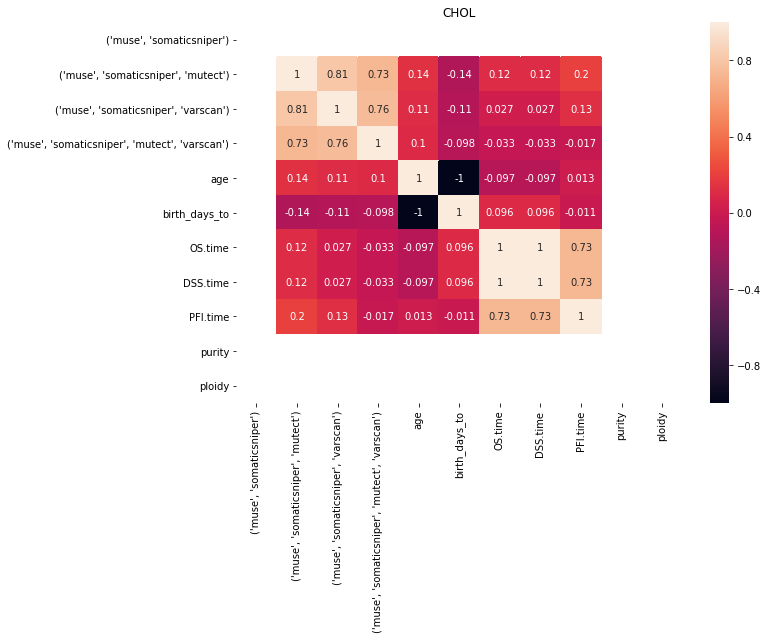

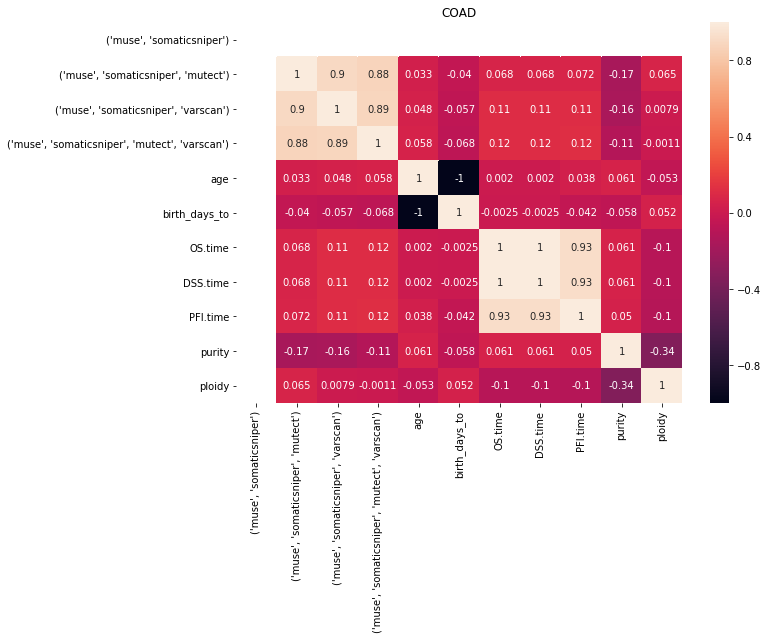

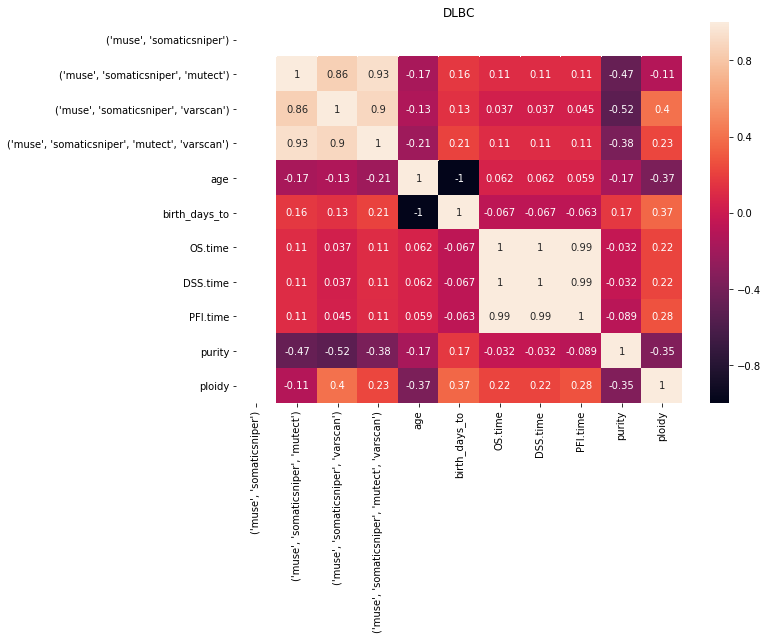

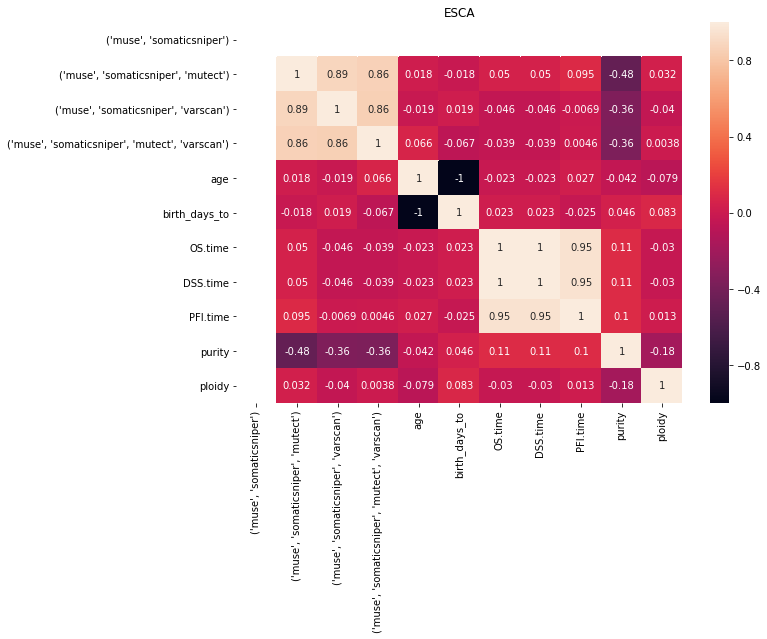

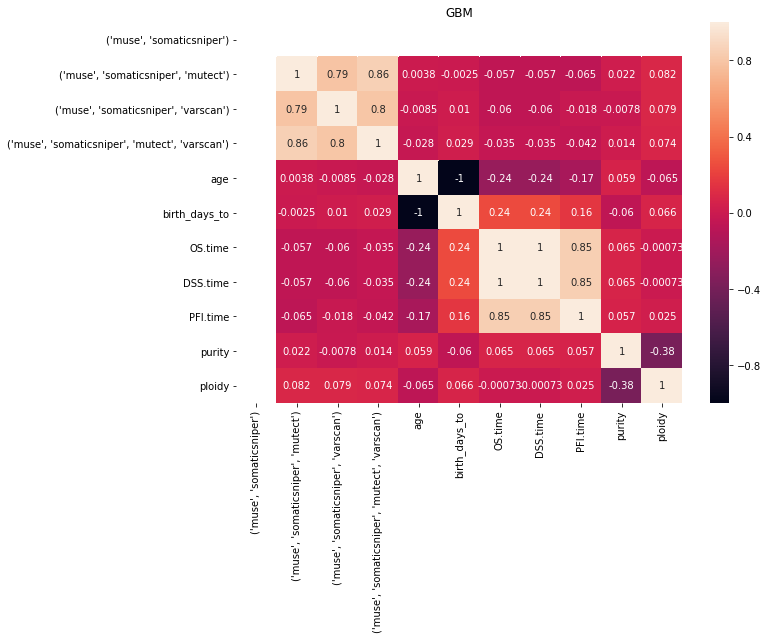

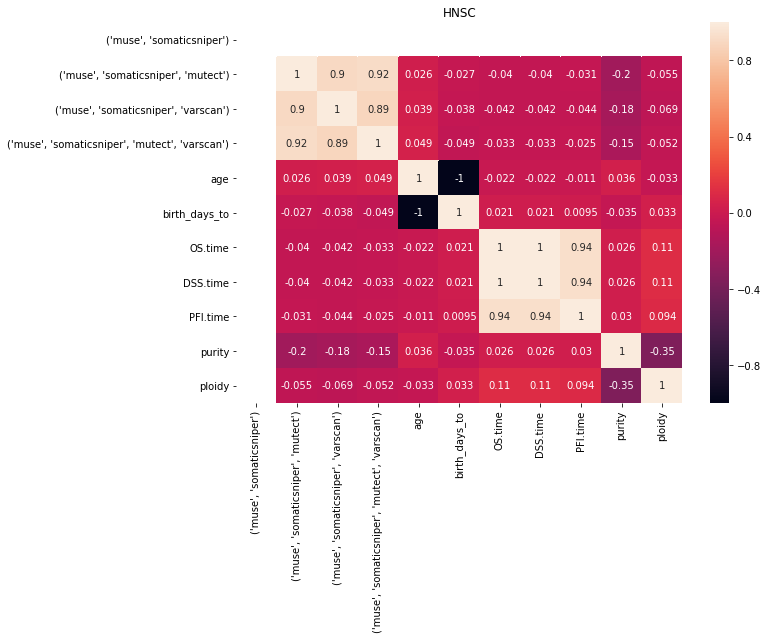

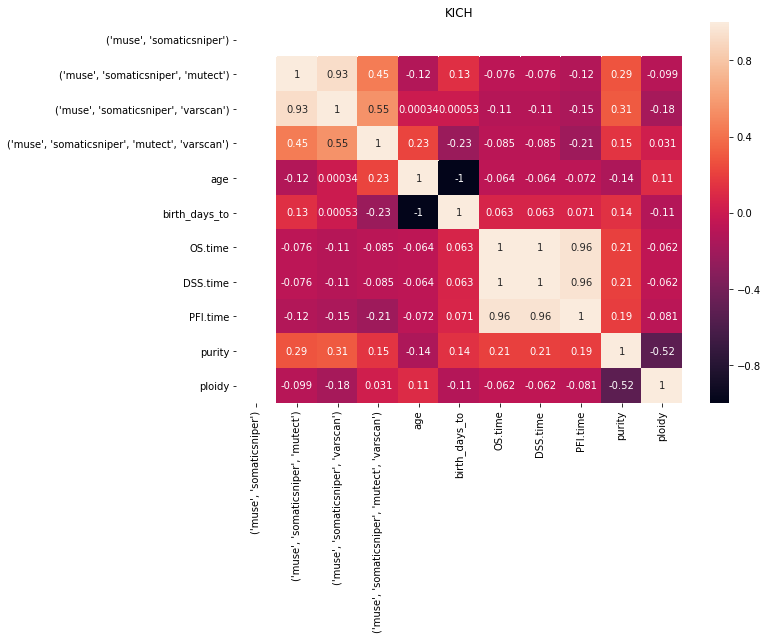

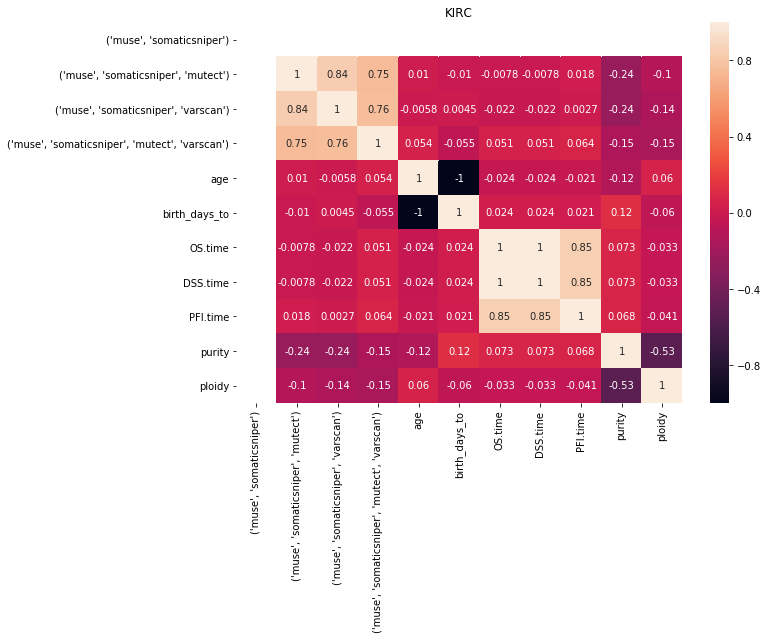

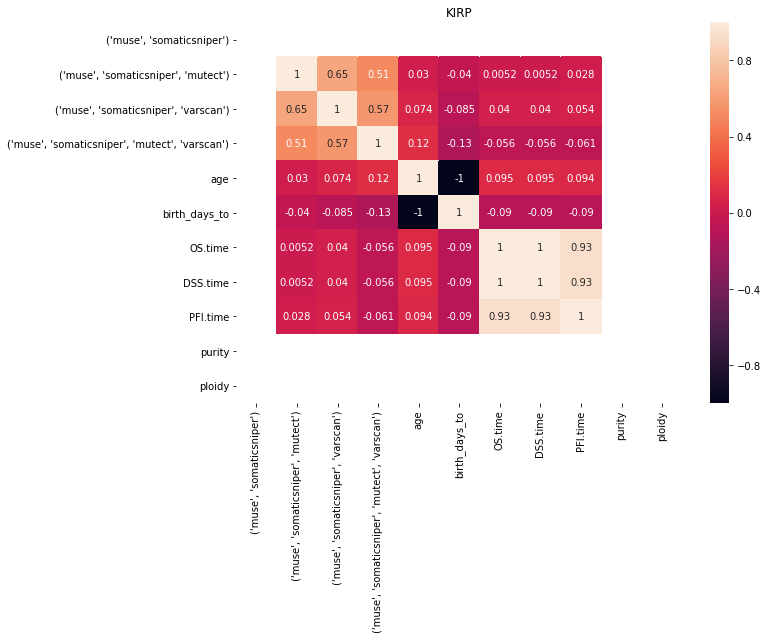

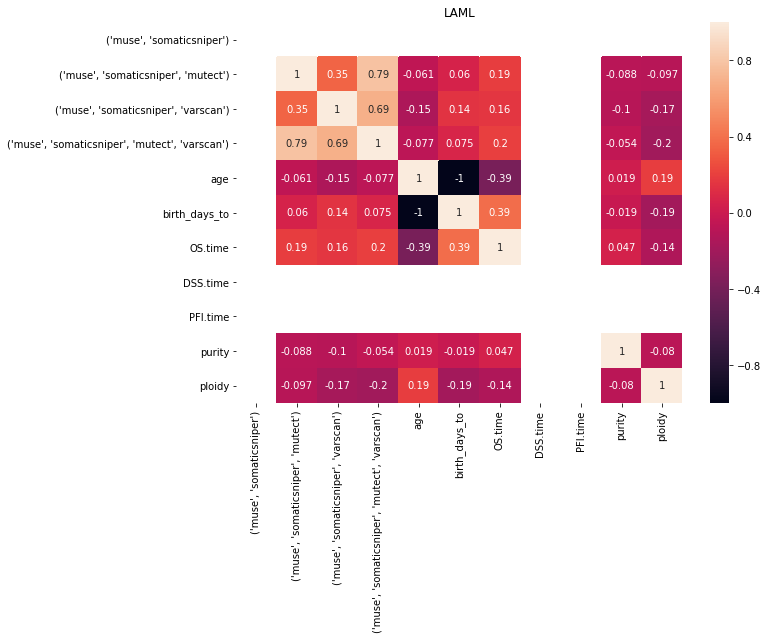

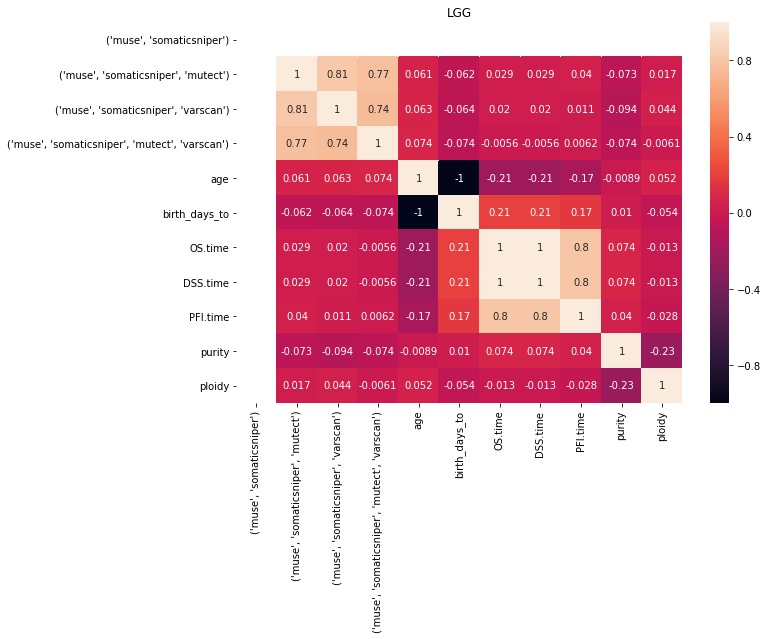

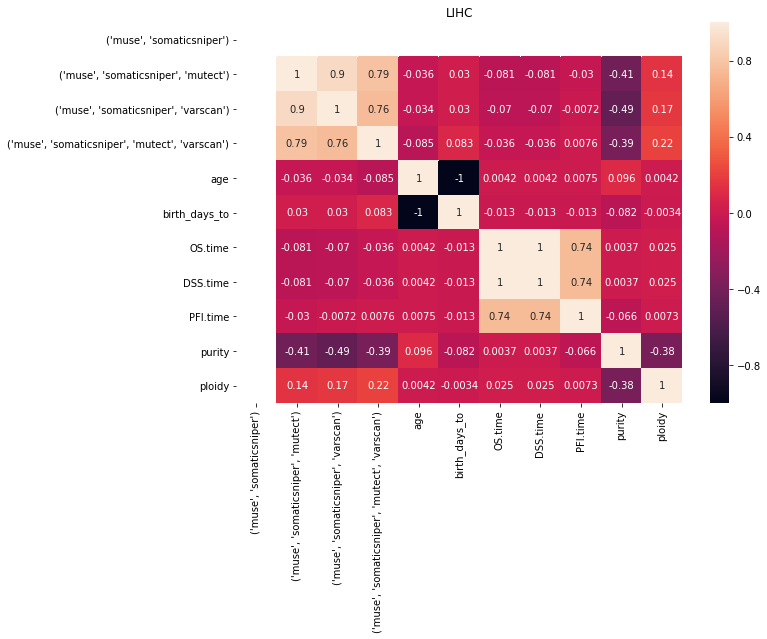

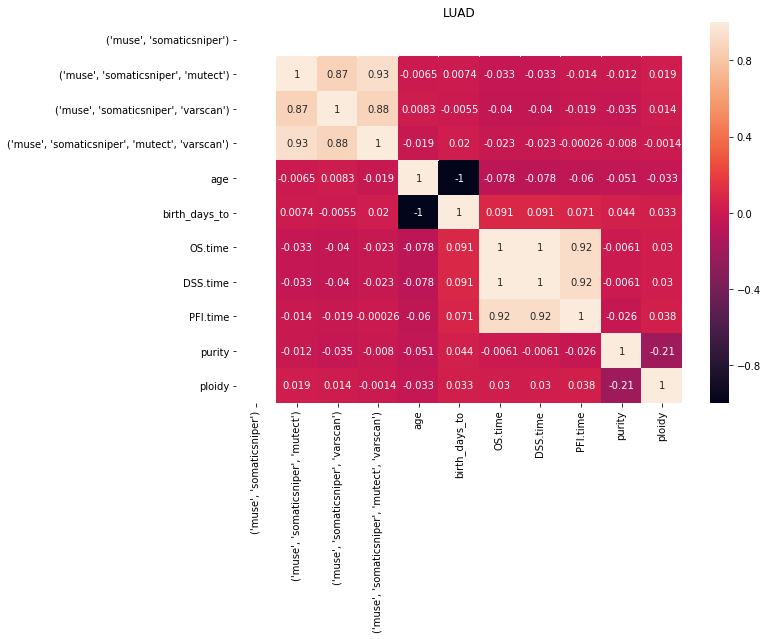

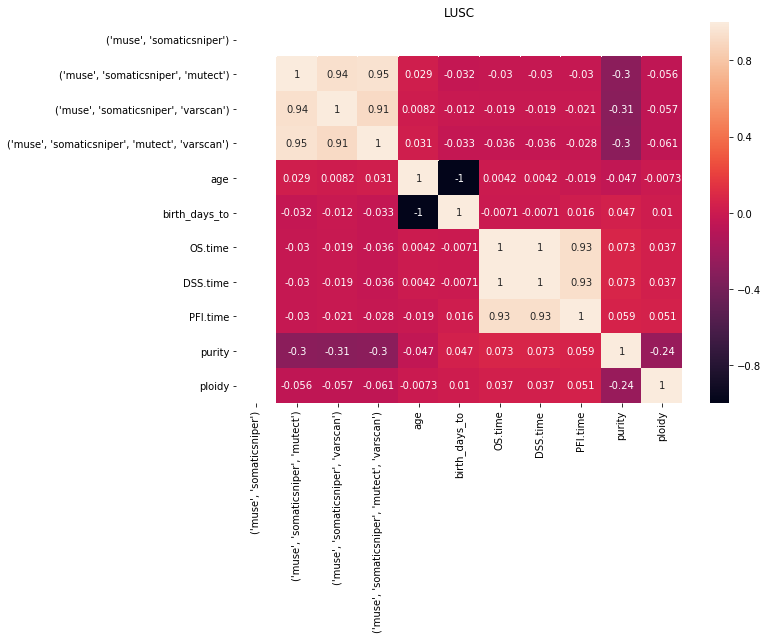

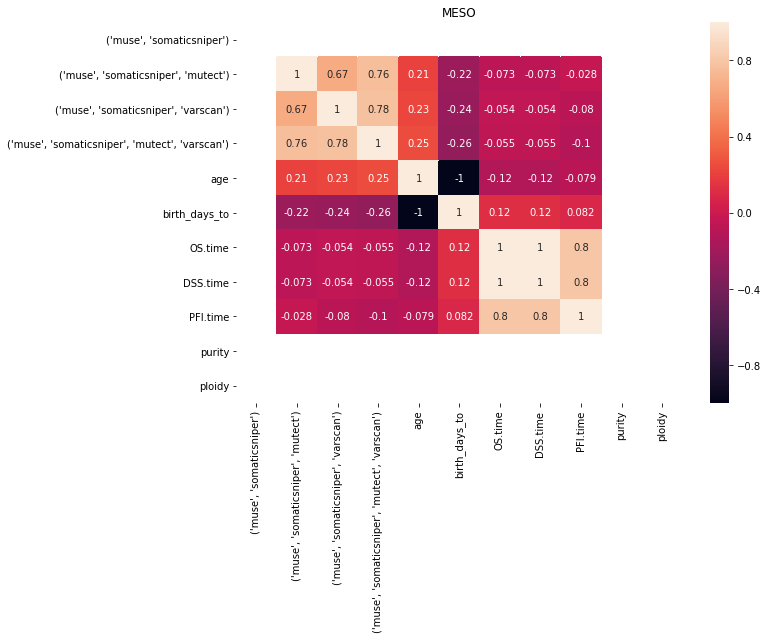

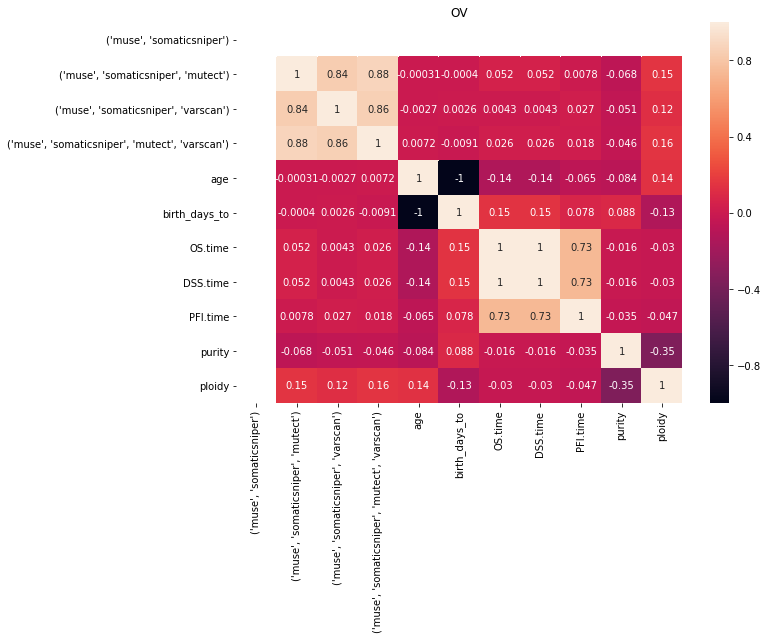

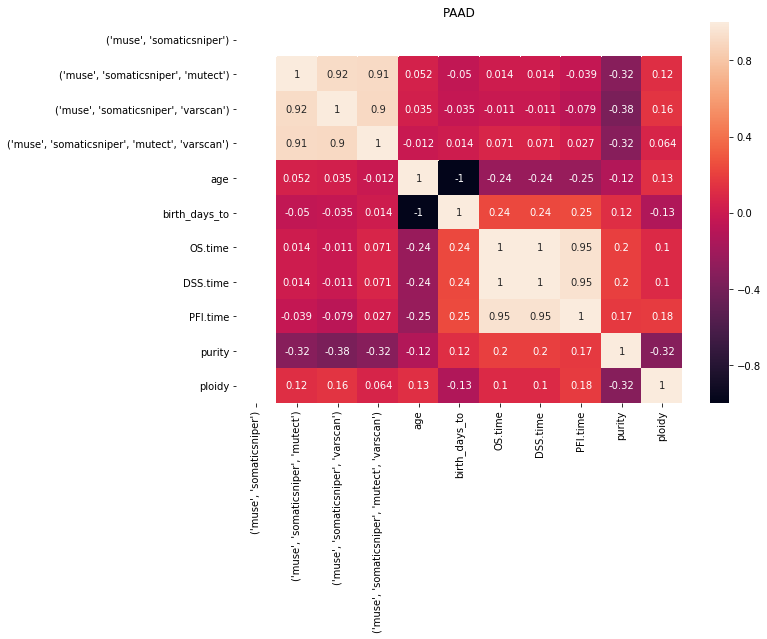

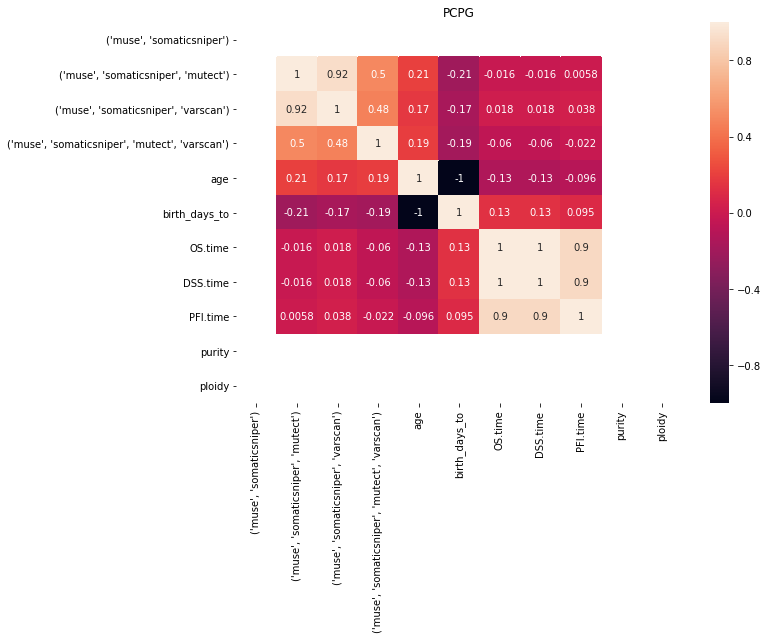

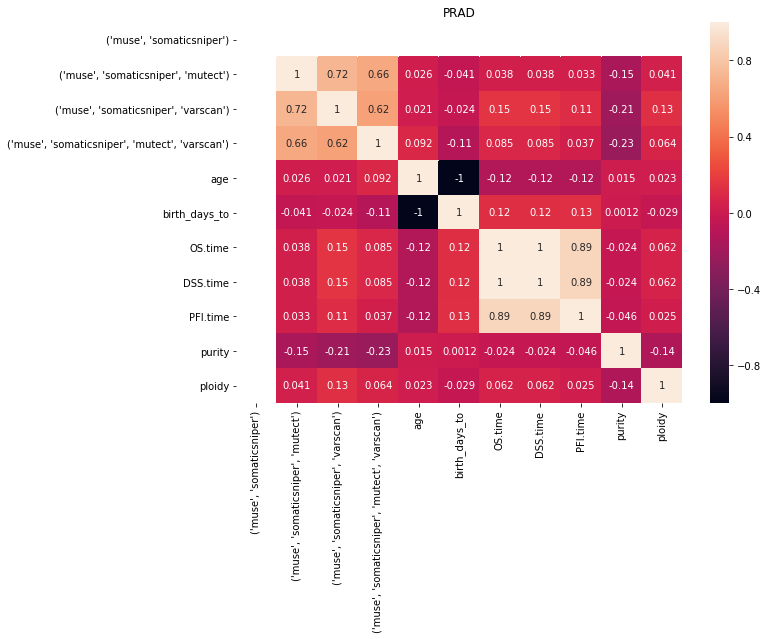

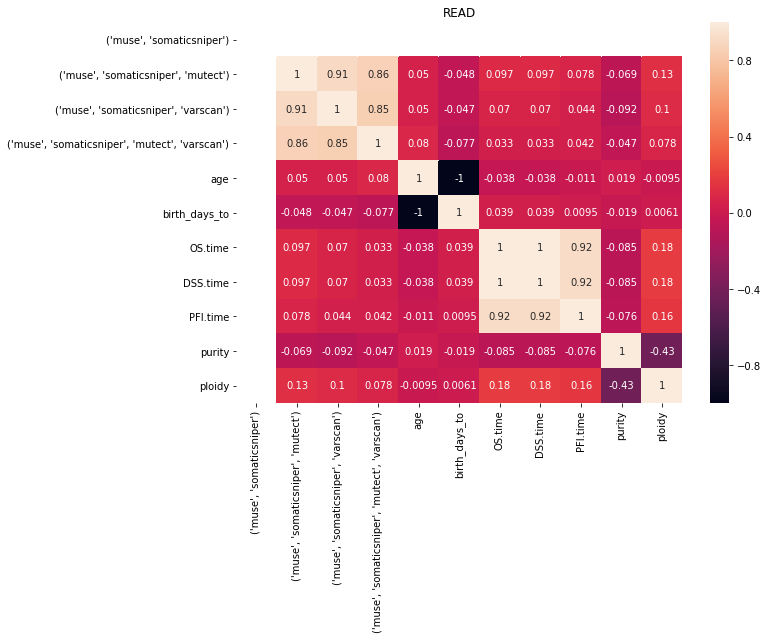

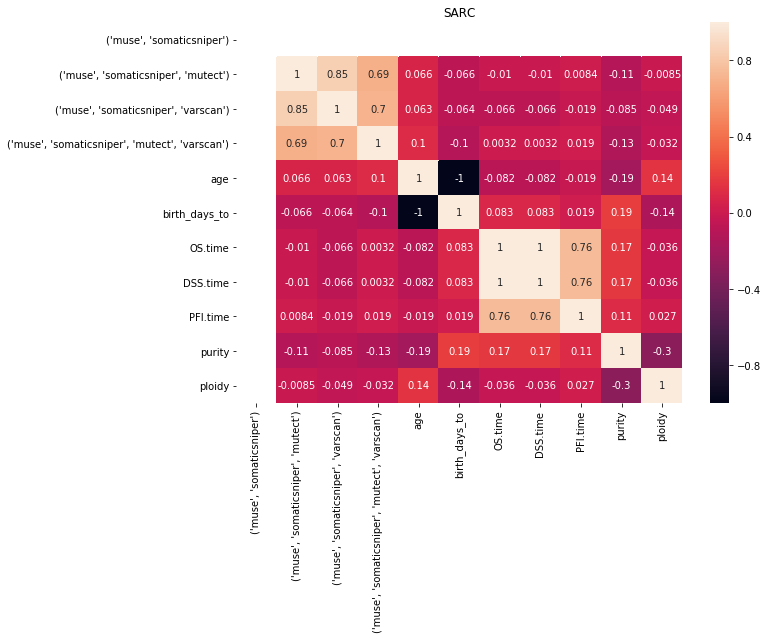

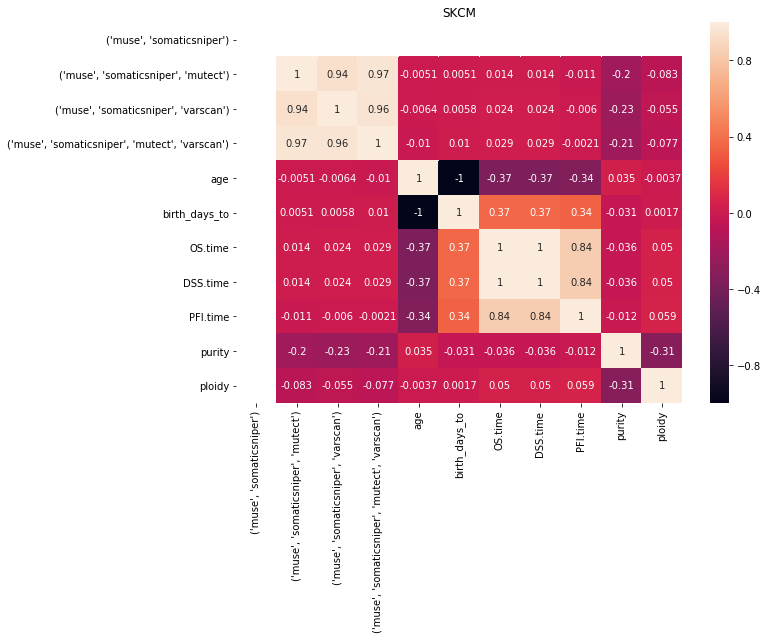

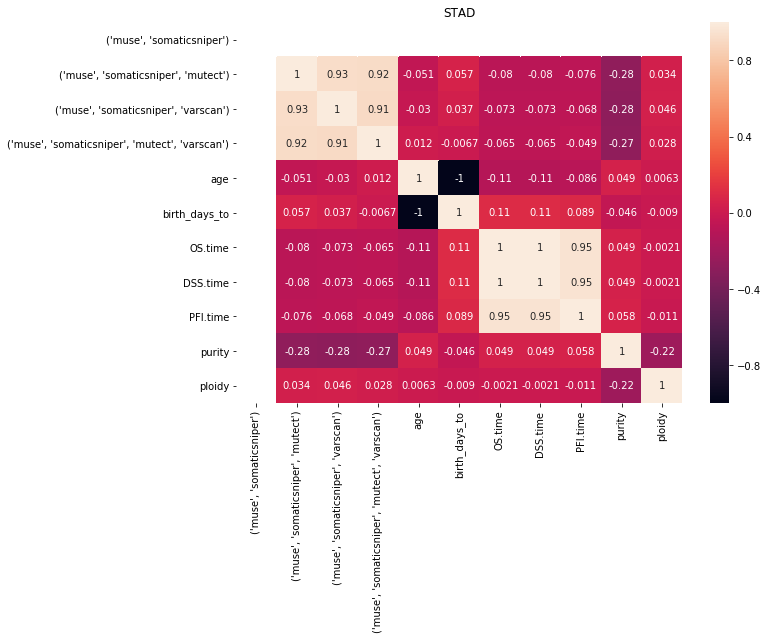

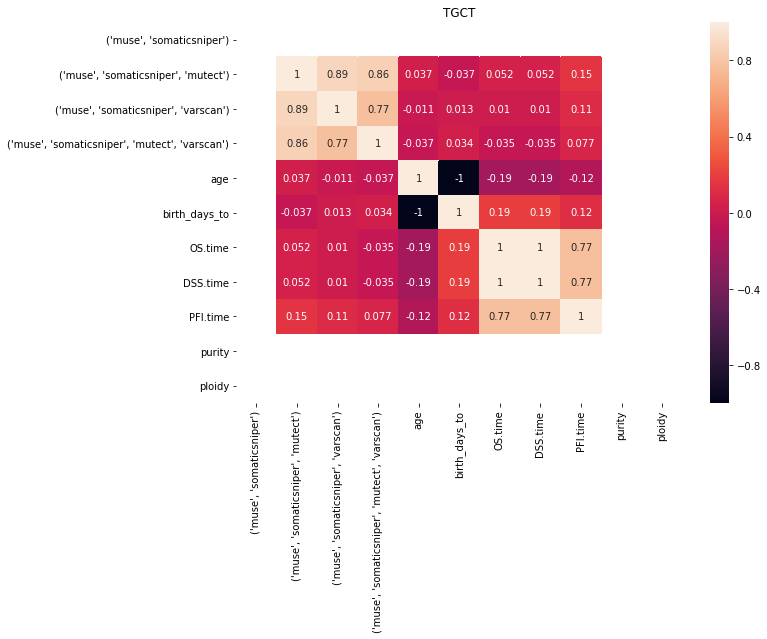

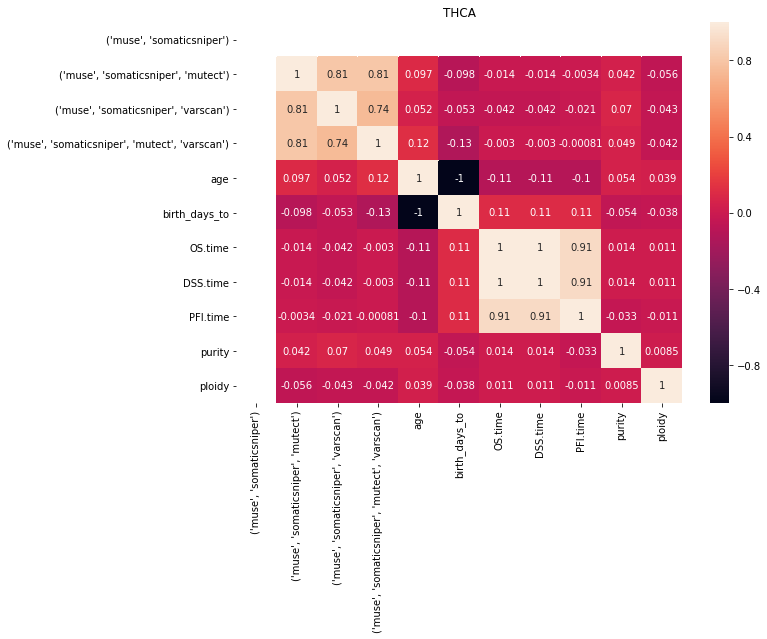

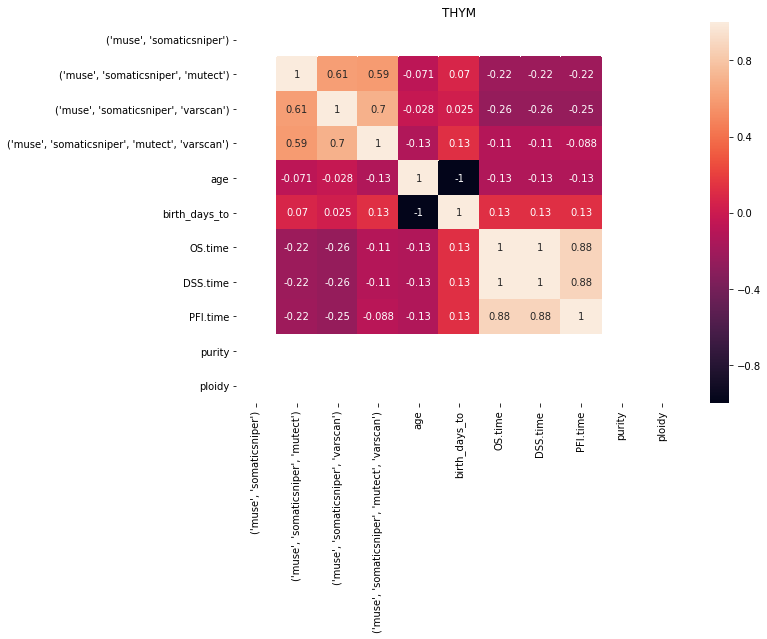

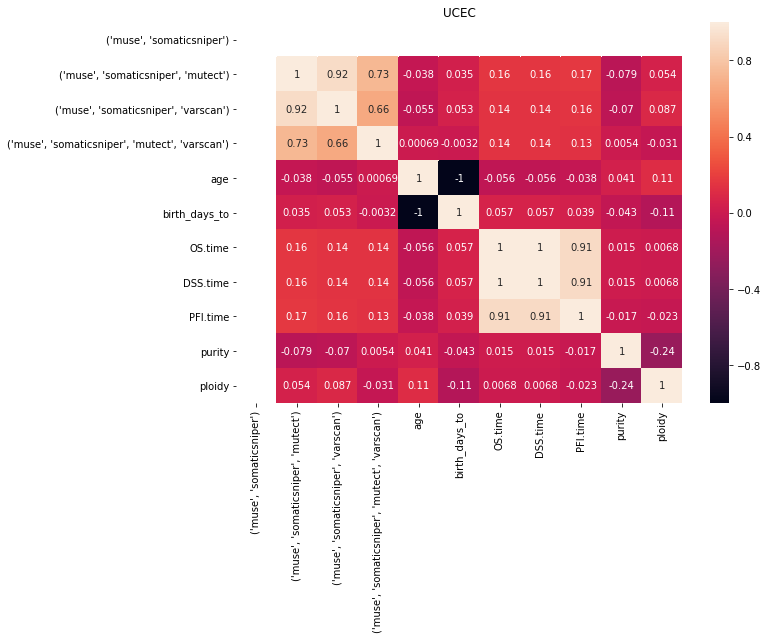

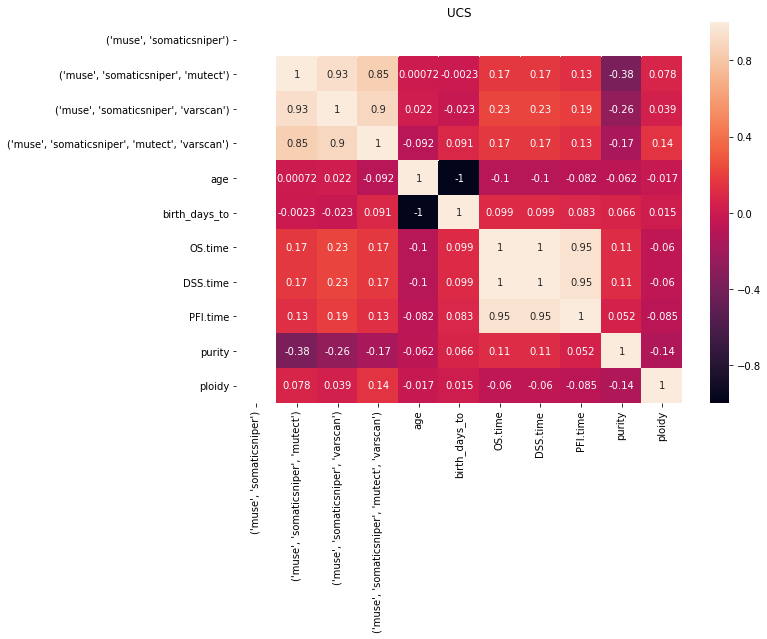

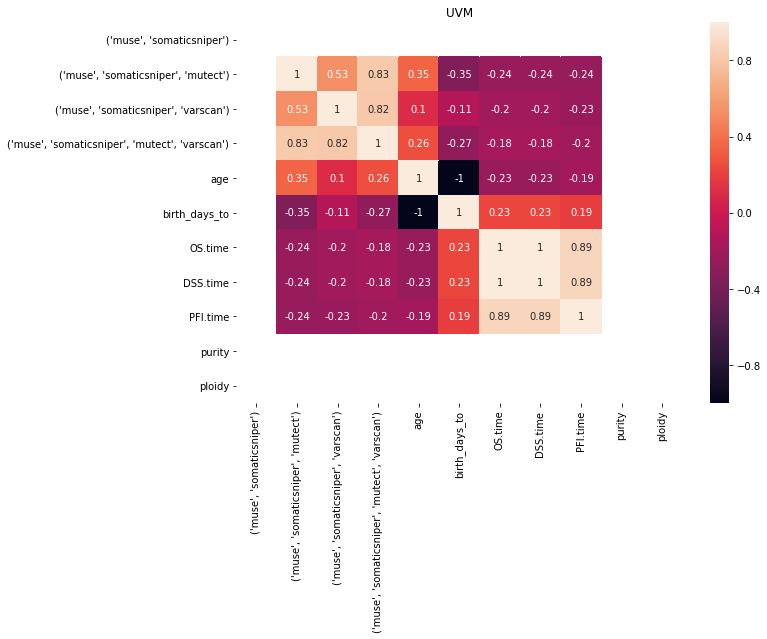

In [9]:
import seaborn as sns
dataframes = {}
# summary statistics, variant callers that always catch a specific variant, map to Bailey 
for cancer in possible_cancers:
    
    os.chdir(original)
    os.chdir(cancer)
    mafs = os.listdir()

    maf_fps = {}
    for caller in possible_callers:
        for maf in mafs:
            if caller in maf: # str in the filepath
                maf_fps[caller] = maf

    all_variants = {}
    new_keys = {}
    new_keys_index = {}
    for caller in maf_fps:
        newkey = []
        all_variants[caller] = parse_maf(maf_fps[caller])
        for key in all_variants[caller].keys():
            newkey.append(key[:12])
        new_keys[caller] = newkey

    arg = []
    for i in range(len(possible_callers)):
        arg.append(all_variants[possible_callers[i]])
    
    oldpatients = set(list(arg[0].keys()))
    for i in range(len(arg)):
        oldpatients = oldpatients & set(list(arg[i].keys()))

    oldpatients = list(oldpatients)

    patients = []
    for patient in oldpatients:
        patients.append(patient[:12])
        
    new_keys_index = dict([(patient, 0) for patient in patients])

    delete = []
    for patient in patients:
        if patient in list(tcga['bcr_patient_barcode']):
            index = tcga.loc[tcga['bcr_patient_barcode'] == patient].index[0]
            new_keys_index[patient] = index
        else:
            delete.append(patient)
            #print(patient)
            #patients.remove(patient)
            del new_keys_index[patient]
    
    for patient in delete:
        patients.remove(patient)
        
    os.chdir(original)

    sets = []
    if len(callers) >= 1:
        sets.append(list(callers))
    ad = my_combs_all(additional_callers, len(additional_callers))

    for n in range(len(ad)):
        sets.append(callers+list(ad[n]))

    for i in range(len(sets)):
        sets[i] = tuple(sets[i])

    df = pd.DataFrame(np.nan, index=patients, columns = sets)

    for n in range(len(patients)):
    
        individual_df = pd.DataFrame(0, index=keys, columns=[cancer,])
        data = dict([(key, []) for key in keys])
        sets = []
        for j in range(len(arg)):
            sets.append(arg[j][oldpatients[n]])
        
        inters = intersections(sets)
    
        for i in range(len(inters)):
            data[keys[i]].extend(list(inters[i]))
        
        individual_df.loc[:,cancer] = how_many_tumor_cgc(data, cgc, filt, impacts, keys)
    
        t = table(callers, additional_callers, cancer, 2, impacts, filt, keys, bcp = individual_df, individual = True, tab = False)        
        for k in range(len(t.index)):
            df.at[patients[n], t.index[k]] = t['real % diff'][k]
    age = []
    birth_days_to = []
    os_time = []
    dss_time = []
    pfi_time = []
    for patient in patients:
        age.append(tcga['age_at_initial_pathologic_diagnosis'][new_keys_index[patient]])
        birth_days_to.append(tcga['birth_days_to'][new_keys_index[patient]])
        os_time.append(tcga['OS.time'][new_keys_index[patient]])
        dss_time.append(tcga['DSS.time'][new_keys_index[patient]])
        pfi_time.append(tcga['PFI.time'][new_keys_index[patient]])
    df['age'] = age
    df['birth_days_to'] = birth_days_to
    df['OS.time'] = os_time
    df['DSS.time'] = dss_time
    df['PFI.time'] = pfi_time
    purity = []
    ploidy = []
    for patient in df.index:
        if patient in list(ascat['Sample']):
            index = ascat.loc[ascat['Sample'] == patient].index[0]
            purity.append(ascat.loc[index]['Aberrant_Cell_Fraction(Purity)'])
            ploidy.append(ascat.loc[index]['Ploidy'])
        else:
            purity.append(np.nan)
            ploidy.append(np.nan)
    df['purity'] = purity
    df['ploidy'] = ploidy
    dataframes[cancer] = df
    corr = df.corr()
    corr.style.background_gradient(cmap='coolwarm')
    pyplot.figure(figsize = (10,7))
    pyplot.title(cancer)
    ax = sns.heatmap(corr, annot=True)
    pyplot.show()
                                         
                                    

PAAD


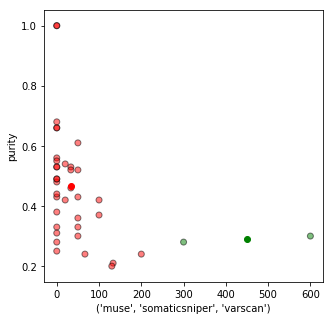

-0.3782862966927955


In [86]:
# criteria for investigating scatter plots: correlation above .10
from sklearn.cluster import KMeans
def scatter_kmeans(cancer, x, y):
    
    print(cancer)
    scatter_df = dataframes[cancer]
    df = pd.DataFrame({x:scatter_df[x], y:scatter_df[y]})
    df = df.drop(i for i in df.index if np.isfinite(df.loc[i][x]) == False or np.isfinite(df.loc[i][y]) == False)
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(df)
    labels = kmeans.predict(df)
    centroids = kmeans.cluster_centers_
    fig = pyplot.figure(figsize=(5, 5))
    colmap = {1: 'r', 2: 'g'}
    colors = list(map(lambda p: colmap[p+1], labels))
    pyplot.scatter(df[x], df[y], alpha=0.5, color = colors, edgecolor='k')
    
    for idx, centroid in enumerate(centroids):
        pyplot.scatter(*centroid, color = colmap[idx+1])
    
    pyplot.xlabel(x)
    pyplot.ylabel(y)
    pyplot.show()
    
    print(scatter_df.corr()[y][x])


scatter_kmeans('PAAD', ('muse','somaticsniper','varscan'), 'purity')